# Methods

This file contains the methods that were used to generate the associated research. This directory also includes a data visualization App that can be deployed to Streamlit to see the results of the process. 

The raw initial submission data is not shared in this repository. The intial data included the abstracts which were not labeled for public release. The data available here includes the initial datset without the abstracts (itsc_clustered_presentations_no_abstracts.pkl). The similarities (itsc_oral_app_similarities.pkl) produced by the text embedding model from the titles and abstracts are included. 



# Load Data
The primary data source is the spreadsheet data file from the presentation organization portal. It is also possible to load the data after it has been separated into oral and poster dataframes.

The abstracts were initially collected for session organization and not for public publication. This Jupyter notebook displays the steps used to create embeddings from the presentation titles and abstracts. However, since the orginal data is not available for inclusion in this repository, this notebook also enables loading the presentation data without the abstracts. This includes the presentation data and the embeddings created from those abstracts. Loading the embeddings also enables much quicker processing and data exploration as the embeddings take many minutes to calculate.

## Primary Data Source

In [1]:
import pandas as pd

df = pd.read_excel("1.29.25 Abstracts.xlsx")
df = df.rename(columns={'Session':'Original Session',
                        'Submission Name':'Title',
                        'Abstract-Character max 4000-Abstracts will only be used to evaluate quality of talk and topic. They will not be published or able to be edited later.':'Abstract',
                        'Submission ID - 7 digits':'Abstract ID',
                        'Technical Community':'Original Technical Community',
                        'Profile: First Name':'First Name',
                        'Profile: Last Name':'Last Name',
                        })


In [2]:
# Drop any presentations that are missing an abstrct or title
df.dropna(subset=['Title','Abstract'], inplace=True)

In [3]:
import pandas as pd

# Before beginning, make sure all presentations have a session assigned. Unassigned presentations are given the session name, unassigned.

df['Original Session'] = df['Original Session'].fillna('UNASSIGNED')

In [4]:
# Combine Titles and Abstracts with a semicolon in between. This should be the same as + but .agg() handles empty fields or fields that have non-text entries.
df['Title and Abstract'] = df[['Title', 'Abstract',]].agg(': '.join, axis=1)
print(f"Title and Abstract: \n{df['Title and Abstract'].head()}")

Title and Abstract: 
0    Repurposing of low-value biomass into engineer...
1    AI Tools and Text Embedding for Session Organi...
2    Automatic ASABE AIM Session Creation using Mac...
3    Soil and Wastewater Effluent Properties of Oil...
4    MODELLING GULLIES FORMED FROM RILLS : An exper...
Name: Title and Abstract, dtype: object


In [5]:
# Select all ITSC presentations
itsc_df = df[df['Original Technical Community'].str.contains('ITSC-Information Technology, Sensors & Control Systems', case=False, na=False)].copy()

# Select the oral presentations only
itsc_oral_df = itsc_df[~itsc_df['Original Session'].str.contains('POSTER', case=False, na=False)].copy()

### Save dataframes for accessing without the spreadsheet.

In [6]:
import pickle
with open('df_doc.pkl', 'wb') as file:
    pickle.dump(df, file)
with open('itsc_oral_df_doc.pkl', 'wb') as file:
    pickle.dump(itsc_oral_df, file)

## Create Embeddings and Similarities
### Model: cde-small-v1

In [7]:
from sentence_transformers import SentenceTransformer
# Line below should be uncommented to run. It must be commented out for Git commit as its output is interpreted as containing a secret. 
cde_embeddings_model = SentenceTransformer('jxm/cde-small-v1', trust_remote_code=True)
print("Model Card:\n", cde_embeddings_model.model_card_data)
print("Similarity Function (None defaults to cosine): ", cde_embeddings_model.similarity_fn_name)
print("Max Token Length:", cde_embeddings_model.tokenizer.model_max_length)

c:\py-venvs\text_sort\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>
<All keys matched successfully>


Model Card:
 tags:
- sentence-transformers
- sentence-similarity
- feature-extraction
pipeline_tag: sentence-similarity
library_name: sentence-transformers
Similarity Function (None defaults to cosine):  cosine
Max Token Length: 512


In [8]:
# Text to embed
doc_topics = itsc_oral_df['Title and Abstract'].tolist()

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Tokenizer maximum sequence length: 512


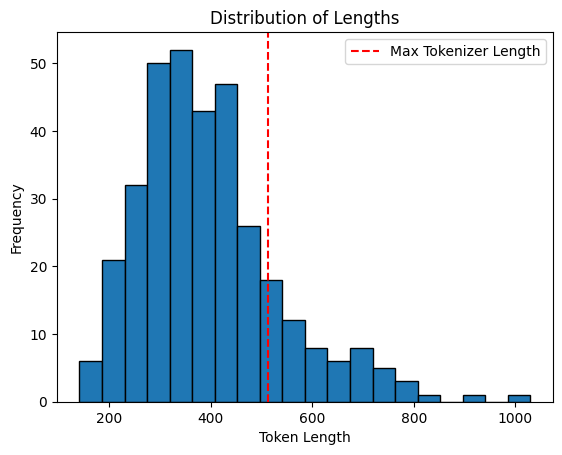

In [9]:
cde_tokenizer = cde_embeddings_model.tokenizer
cde_max_length = cde_tokenizer.model_max_length
print(f"Tokenizer maximum sequence length: {cde_max_length}")
cde_tokenized_lengths = [len(cde_tokenizer.tokenize(text)) for text in doc_topics]
cde_token_out = [cde_tokenizer.tokenize(text, truncation=True, max_length=cde_max_length) for text in doc_topics]
cde_concatenated_output = [" ".join(tokens) for tokens in cde_token_out]  # List of strings

import matplotlib.pyplot as plt
# Plot length  distribution
plt.hist(cde_tokenized_lengths, bins=20, edgecolor='black')
plt.axvline(x=cde_max_length, color='r',
            linestyle='--', label='Max Tokenizer Length')
plt.title('Distribution of Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Embed Presentations

Create the dataset embeddings as required by this model.

In [10]:
import time
import random

minicorpus_size = cde_embeddings_model[0].config.transductive_corpus_size
# Get the unique elements from the original population
#    Using list(set(...)) ensures uniqueness and handles potential duplicates in doc_topics
unique_docs = list(set(doc_topics))
num_unique = len(unique_docs)
if minicorpus_size < num_unique:
    # Put some strings here that are representative of your corpus, for example by calling random.sample(corpus, k=minicorpus_size)
    minicorpus_docs = random.sample(doc_topics, k=minicorpus_size)
else: 
    # Start the minicorpus with all unique documents
    minicorpus_docs = list(unique_docs) # Make a copy to start

    # Calculate how many more documents are needed
    remaining_needed = minicorpus_size - num_unique

    # If more are needed, sample *with replacement* from the *original* population
    if remaining_needed > 0:
        # Sample the remaining items randomly WITH replacement from the original doc_topics
        additional_docs = random.choices(doc_topics, k=remaining_needed)
        # Add these to the minicorpus
        minicorpus_docs.extend(additional_docs)
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.


start_time = time.time()
cde_dataset_embeddings = cde_embeddings_model.encode(
    minicorpus_docs,
    prompt_name="document",
    convert_to_tensor=True
)
end_time = time.time()
cde_dataset_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(cde_dataset_embeddings)}, Length of Vectors: {len(cde_dataset_embeddings[0])}")
print(f"Dataset Encoding time: {cde_dataset_elapsed_time:.4f} seconds")

Titles Embedded: 512, Length of Vectors: 768
Dataset Encoding time: 26.8804 seconds


Then perform the main embedding

In [11]:
start_time = time.time()
cde_doc_embeddings = cde_embeddings_model.encode(
    doc_topics,
    prompt_name="document",
    dataset_embeddings=cde_dataset_embeddings,
    convert_to_tensor=True,
)
end_time = time.time()
cde_doc_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(cde_doc_embeddings)}, Length of Vectors: {len(cde_doc_embeddings[0])}")
print(f"Document Encoding time: {cde_doc_elapsed_time:.4f} seconds")
cde_elapsed_time = cde_doc_elapsed_time+cde_dataset_elapsed_time
print(f"Total Encoding time: {(cde_elapsed_time):.4f} seconds")

Titles Embedded: 340, Length of Vectors: 768
Document Encoding time: 216.8433 seconds
Total Encoding time: 243.7237 seconds


In [13]:
cde_similarities = cde_embeddings_model.similarity(cde_doc_embeddings, cde_doc_embeddings)
# Convert similarity matrix to a dataframe (will use dataframe as it is easier to drop index values)
itsc_oral_similarities_df = pd.DataFrame(cde_similarities.cpu(), index = itsc_oral_df.index, columns=itsc_oral_df.index)
itsc_oral_embeddings_df = pd.DataFrame(cde_doc_embeddings.cpu(), index = itsc_oral_df.index)

Save the similarities as a dataframe and as a tensor pickle

In [14]:
import torch
itsc_oral_similarities_df.to_pickle('itsc_similarities.pkl')
itsc_oral_embeddings_df.to_pickle('itsc_embeddings.pkl')
torch.save(cde_doc_embeddings, 'itsc_embeddings.pt')
torch.save(cde_similarities, 'itsc_similarities.pt')

## Load Data
This enables starting at this point without re-embedding the presentations.
Code can be commented out to skip.

In [1]:
import pickle
import torch
import pandas as pd

# For loading base oral dataframe:
with open('df_doc.pkl', 'rb') as file:
    df = pickle.load(file)
with open('itsc_oral_df_doc.pkl', 'rb') as file:
    itsc_oral_df = pickle.load(file)
doc_topics = itsc_oral_df['Title and Abstract'].tolist()

# Load the similarity matrices (will use dataframe as it is easier to manage)
# cde_similarities = torch.load('itsc_embeddings.pt', weights_only=False)
itsc_oral_similarities_df = pd.read_pickle('itsc_similarities.pkl')
itsc_oral_embeddings_df = pd.read_pickle('itsc_embeddings.pkl')

## Create Dataframes
Presentations and the associated Similarity matrices need matching indices.

Find duplicates or nearly identical presentations. Some presentations appear to have been resubmissions to correct typos. They are not strictly duplicates, but should not be considered any further. They would be removed in manual sorting anyhow.

In [2]:
import pandas as pd
import numpy as np

# --- Ensure indices are aligned across these three dataframes ---

print(f"Original number of oral presentations: {len(itsc_oral_df)}")
print(f"Original shape of similarities matrix: {itsc_oral_similarities_df.shape}")
print(f"Original shape of embeddings matrix: {itsc_oral_embeddings_df.shape}")

# Define the similarity threshold for considering items as near duplicates
# Difference < 0.01 means Similarity >= 0.99
similarity_threshold = 0.99

# Get the indices from the dataframe (important for referencing)
presentation_indices = itsc_oral_similarities_df.index.tolist()
index_map = {i: idx for i, idx in enumerate(presentation_indices)} # Map position to actual index

# Create a set to store the indices we want to REMOVE
indices_to_remove = set()

# Iterate through the upper triangle of the similarity matrix to avoid redundant checks and self-comparison
# Use iloc for positional indexing which is often faster for loops
similarity_matrix_np = itsc_oral_similarities_df.values # Get numpy array for faster access
num_items = similarity_matrix_np.shape[0]

for i in range(num_items):
    for j in range(i + 1, num_items): # Start j from i+1 to get upper triangle
        similarity_score = similarity_matrix_np[i, j]

        if similarity_score >= similarity_threshold:
            # Found a near-duplicate pair
            index_i = index_map[i] # Get the actual index value
            index_j = index_map[j] # Get the actual index value

            # Identify the index to remove (the one with the lower value)
            index_to_drop = min(index_i, index_j)
            index_to_keep = max(index_i, index_j)

            # Add the lower index to the set for removal
            indices_to_remove.add(index_to_drop)
            # Optional: print information about the identified pair
            # print(f"Near duplicate found: Index {index_i} and Index {index_j} (Similarity: {similarity_score:.4f}). Keeping {index_to_keep}, removing {index_to_drop}.")


# Convert the set of indices to remove into a list
indices_to_remove_list = sorted(list(indices_to_remove)) # Sorting is optional but good practice

print(f"\nFound {len(indices_to_remove_list)} near-duplicate presentations to remove (keeping highest index).")
print(f"Indices to remove: {indices_to_remove_list}")

# --- Perform the removal ---

# Keep only the rows whose indices are NOT in the removal list
itsc_oral_df = itsc_oral_df.drop(index=indices_to_remove_list)
itsc_oral_embeddings_df = itsc_oral_embeddings_df.drop(index=indices_to_remove_list)

# For the square similarity matrix, remove both rows and columns
itsc_oral_similarities_df = itsc_oral_similarities_df.drop(index=indices_to_remove_list, columns=indices_to_remove_list)

# --- Verification ---
print(f"\nFinal number of oral presentations: {len(itsc_oral_df)}")
print(f"Final shape of similarities matrix: {itsc_oral_similarities_df.shape}")
print(f"Final shape of embeddings matrix: {itsc_oral_embeddings_df.shape}")

# Verify indices still match
if not itsc_oral_df.index.equals(itsc_oral_embeddings_df.index):
     print("Warning: Indices of itsc_oral_df and itsc_oral_embeddings_df do not match!")
if not itsc_oral_df.index.equals(itsc_oral_similarities_df.index):
     print("Warning: Row indices of itsc_oral_df and itsc_oral_similarities_df do not match!")
if not itsc_oral_similarities_df.index.equals(itsc_oral_similarities_df.columns):
     print("Warning: Row and Column indices of itsc_oral_similarities_df do not match!")

# You can now use itsc_oral_df, itsc_oral_embeddings_df, and itsc_oral_similarities_df

Original number of oral presentations: 340
Original shape of similarities matrix: (340, 340)
Original shape of embeddings matrix: (340, 768)

Found 4 near-duplicate presentations to remove (keeping highest index).
Indices to remove: [221, 223, 497, 762]

Final number of oral presentations: 336
Final shape of similarities matrix: (336, 336)
Final shape of embeddings matrix: (336, 768)


In [3]:
# Check for duplicate rows based on all columns
duplicates_check = itsc_oral_df.duplicated(subset=['Title and Abstract'])

# See which rows are marked as duplicates
print(itsc_oral_df[duplicates_check])

Empty DataFrame
Columns: [Original Session, Title, Abstract, Abstract ID, Original Technical Community, First Name, Last Name, Title and Abstract]
Index: []


In [4]:
# Check to make sure indicies are the same
all(itsc_oral_df.index == itsc_oral_similarities_df.index)

True

Since the dataframes that are being processed are selections from other dataframes, not all indices are present. Reset indices for the presentations and the similarity dataframes. Then convert the similarity dataframes to numpy arrays and tensors for processing. The array indices for the similarity numpy arrays match the row indices for the presentation dataframe.

In [5]:
itsc_oral_df = itsc_oral_df.reset_index()
itsc_oral_similarities_df.reset_index(drop=True, inplace=True)
itsc_oral_embeddings_df.reset_index(drop=True, inplace=True)
# Convert the similarities DataFrame to a NumPy array (this will drop/reset the index and columns)
itsc_oral_similarities_np = itsc_oral_similarities_df.values
# Convert the NumPy array to a PyTorch tensor
itsc_oral_similarities_tensor = torch.tensor(itsc_oral_similarities_np, dtype=torch.float32)

### Save the reindexed dataframe for use in a data exploration app.

In [6]:
itsc_oral_similarities_app_df = pd.DataFrame(itsc_oral_similarities_tensor.cpu(), index = itsc_oral_df.index, columns=itsc_oral_df.index)
itsc_oral_similarities_app_df.to_pickle('itsc_oral_app_similarities.pkl')
itsc_oral_embeddings_df.to_pickle('itsc_oral_app_embeddings.pkl')

# Session Analysis Functions

In [4]:
# These functions are used to build cluster lists and calculate cluster similarities from the original dataframes for analysis and plotting.
# The analysis functions expect this format as they were designed to work with the output from the clustering algorithms.
import numpy as np
import pandas as pd

def calculate_cluster_similarities(similarity_matrix, labels):
    """
    Calculate average similarity of each document with others in its cluster
    
    Returns:
    - document_similarities: Average similarity of each document with its cluster
    - cluster_avg_similarities: Average similarity for each cluster
    """
    n_samples = len(labels)
    document_similarities = np.zeros(n_samples)
    cluster_avg_similarities = {}
    
    for i in range(n_samples):
        # Get indices of other documents in the same cluster
        cluster_idx = np.where(labels == labels[i])[0]
        cluster_idx = cluster_idx[cluster_idx != i]  # Exclude self
        
        if len(cluster_idx) > 0:  # If there are other documents in the cluster
            # Calculate average similarity with other documents in cluster
            document_similarities[i] = np.mean(similarity_matrix[i, cluster_idx])
        
    # Calculate average similarity for each cluster
    unique_clusters = np.unique(labels)
    for cluster in unique_clusters:
        cluster_mask = labels == cluster
        cluster_docs = np.where(cluster_mask)[0]
        
        if len(cluster_docs) > 1:
            cluster_similarities = []
            for doc in cluster_docs:
                other_docs = cluster_docs[cluster_docs != doc]
                avg_sim = np.mean(similarity_matrix[doc, other_docs])
                cluster_similarities.append(avg_sim)
            cluster_avg_similarities[cluster] = np.mean(cluster_similarities)
        else:
            cluster_avg_similarities[cluster] = 0.0
            
    return document_similarities, cluster_avg_similarities


def create_session_index_lists(oral_df, session_column='Original Session'):
    """
    Creates a list of lists, where each inner list contains the indices of presentations
    assigned to a particular session.

    Args:
        oral_df (pd.DataFrame): The DataFrame containing presentation data.
        session_column (str): The name of the column containing session names.

    Returns:
        list: A list of lists, where each inner list contains indices for a session.
        dict: A dictionary mapping session names to their corresponding indices.
    """
    # Reset index to ensure consistent indexing (similarity tensor is re-indexed)
    oral_df.reset_index(drop=True, inplace=True)  
    session_indices = {}
    for index, session in oral_df[session_column].items():
        if session not in session_indices:
            session_indices[session] = []
        session_indices[session].append(index)

    return list(session_indices.values()), session_indices

## Basic Similarity Characteristics

In [9]:
# Create a mask that is True for off-diagonal elements
mask = np.ones(itsc_oral_similarities_tensor.cpu().numpy().shape, dtype=bool)
np.fill_diagonal(mask, False)
average_similarity = np.mean(itsc_oral_similarities_tensor.cpu().numpy()[mask])
print(f"Average Similarity for all presentations to each other: {average_similarity:.4f}")
min_similarity = np.min(itsc_oral_similarities_tensor.cpu().numpy()[mask])
print(f"Minimum Similarity for any two presentations: {min_similarity:.4f}")
max_similarity = np.max(itsc_oral_similarities_tensor.cpu().numpy()[mask])
print(f"Maximum Similarity for any two presentations: {max_similarity:.4f}")

Average Similarity for all presentations to each other: 0.5448
Minimum Similarity for any two presentations: 0.2171
Maximum Similarity for any two presentations: 0.9268


In [3]:
def analyze_sessions(sessions_dict, similarities):
    """
    Calculates statistics for sessions using a dictionary and a NumPy similarity matrix.

    Args:
        sessions_dict (dict): A dictionary where keys are session names 
                              and values are lists of indices of items in that session.
        similarities (np.ndarray): The cosine similarity matrix as a NumPy array.

    Returns:
        dict: A dictionary containing the calculated statistics:
              - 'avg_similarity': Overall average similarity across sessions with > 1 item.
              - 'min_session_similarity': Minimum average similarity found in any session with > 1 item.
              - 'num_sessions': Total number of sessions.
              - 'clusters_gt1': Number of sessions with more than one item.
              - 'session_sizes': A dictionary mapping session names to their sizes.
              - 'similarity_values': A dictionary mapping session names to their average internal similarity.
    """
    # Initialize dictionaries to store results for each session
    session_similarities = {}
    session_sizes = {}
    clusters_gt1 = 0 # Counter for sessions with more than one item

    # Iterate through each session in the input dictionary
    for session_name, session_indices in sessions_dict.items():
        # Store the size (number of items) of the current session
        session_sizes[session_name] = len(session_indices)
        
        # Calculate similarity only for sessions with more than one item
        if len(session_indices) > 1:
            clusters_gt1 += 1 # Increment the counter for sessions > size 1
            
            # Use numpy advanced indexing (np.ix_) to extract the submatrix 
            # corresponding to the current session's indices
            session_similarity_matrix = similarities[np.ix_(session_indices, session_indices)]
            
            # Calculate the sum of the upper triangle of the submatrix (excluding the diagonal)
            # This sums the similarities between unique pairs within the session
            similarity_sum = np.sum(np.triu(session_similarity_matrix, k=1))
            
            # Calculate the number of unique pairs in the session
            num_pairs = len(session_indices) * (len(session_indices) - 1) / 2
            
            # Calculate the average similarity for the session
            # Handle the case where num_pairs might be zero (although guarded by len > 1 check)
            avg_session_similarity = similarity_sum / num_pairs if num_pairs > 0 else 0.0
            
            # Store the calculated average similarity for the session
            session_similarities[session_name] = avg_session_similarity
            
        # For sessions with only one item, similarity is not meaningful (set to 0)
        elif len(session_indices) == 1:
            session_similarities[session_name] = 0.0 
        # For empty sessions, similarity is 0
        else:
            session_similarities[session_name] = 0.0 

    # Calculate the overall average similarity and minimum similarity across sessions with > 1 item.
    # Iterate through the calculated similarities, checking the original session size.
    valid_similarities = [
        sim for session_name, sim in session_similarities.items() 
        if len(sessions_dict.get(session_name, [])) > 1 
    ] # Filter to include only similarities from sessions with more than one item.
    
    overall_avg_similarity = np.mean(valid_similarities) if valid_similarities else 0.0
    min_session_similarity = min(valid_similarities) if valid_similarities else 0.0

    # Compile the results into a dictionary
    results = {
        'avg_similarity': overall_avg_similarity,
        'min_session_similarity': min_session_similarity,
        'num_sessions': len(sessions_dict),
        'clusters_gt1': clusters_gt1,
        'session_sizes': session_sizes, # Dictionary of session_name: size
        'similarity_values': session_similarities, # Dictionary of session_name: avg_similarity
    }

    return results



# Original Presentation Distribution

The average session similarity after submission is 0.5751040464355832
Average Session Similarity*: 0.604
Minimum Session Similarity*: 0.511
Number of Sessions: 21
Number of sessions with more than 1 item: 20
Presentations placed in sessions: 336
*Only calculated using sessions with more than 1 item.


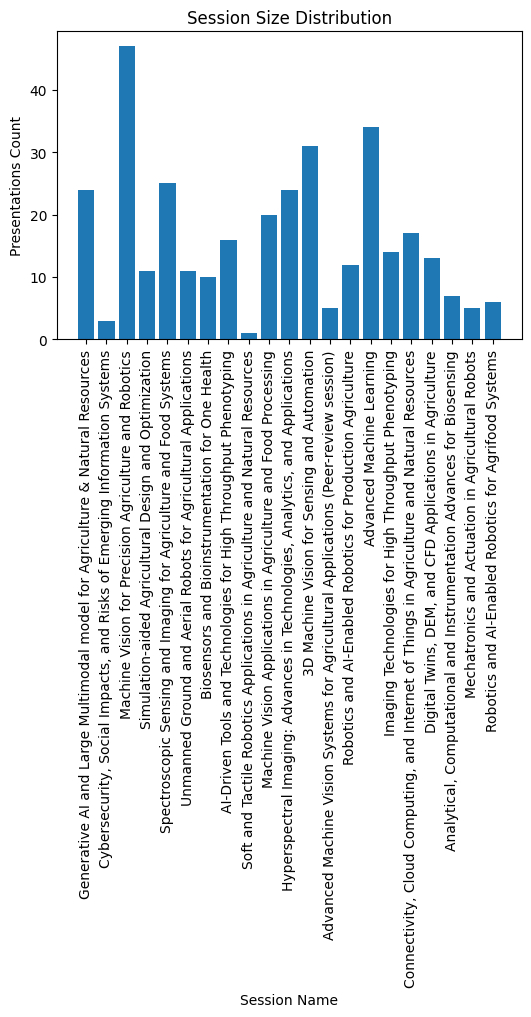

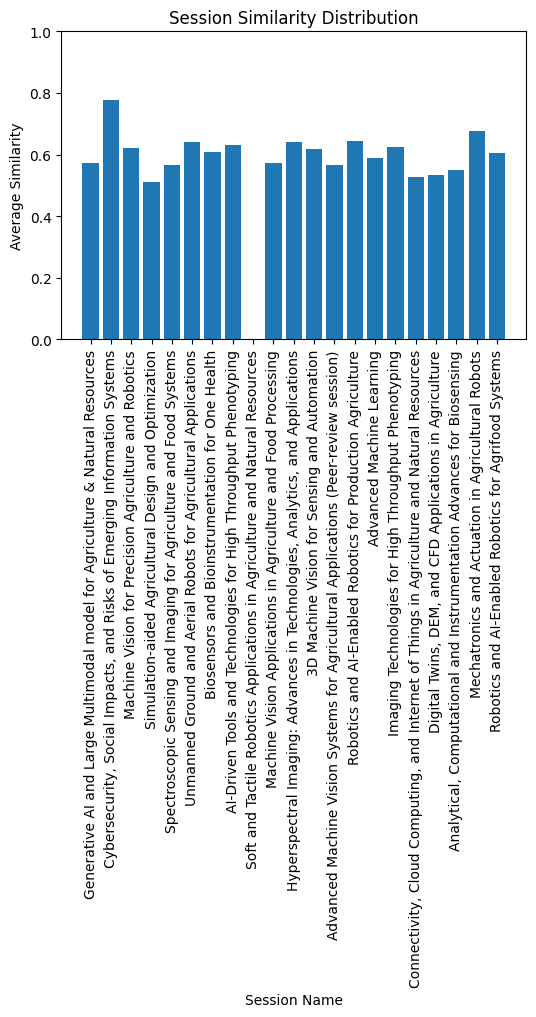

In [11]:

pres_session_similarity, session_similarity = calculate_cluster_similarities(itsc_oral_similarities_tensor.cpu().numpy(), np.array(itsc_oral_df['Original Session']))
print(f"The average session similarity after submission is {np.mean(list(session_similarity.values()))}")
original_session_list, original_session_dict = create_session_index_lists(itsc_oral_df)
original_analysis_results = analyze_sessions(original_session_dict, itsc_oral_similarities_tensor.cpu().numpy())
print(f"Average Session Similarity*: {original_analysis_results['avg_similarity']:.3f}")
print(f"Minimum Session Similarity*: {original_analysis_results['min_session_similarity']:.3f}")
print(f"Number of Sessions: {original_analysis_results['num_sessions']}")
print(f"Number of sessions with more than 1 item: {original_analysis_results['clusters_gt1']}")
print(f"Presentations placed in sessions: {sum([len(s) for s in original_session_list])}")
print(f"*Only calculated using sessions with more than 1 item.")
# Plot session sizes
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(original_analysis_results['session_sizes'].keys(), original_analysis_results['session_sizes'].values())
ax.set_ylabel("Presentations Count")
ax.set_xlabel("Session Name")
ax.set_xticks(list(original_analysis_results['session_sizes'].keys()))
ax.set_xticklabels([str(session) for session in original_analysis_results['session_sizes'].keys()], rotation=90)
ax.set_title("Session Size Distribution")
plt.show()

# Plot session similarities
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(original_analysis_results['similarity_values'].keys(), original_analysis_results['similarity_values'].values())
ax.set_ylabel("Average Similarity")
ax.set_ylim(0, 1)
ax.set_xlabel("Session Name")
ax.set_xticks(list(original_analysis_results['similarity_values'].keys()))
ax.set_xticklabels([str(session) for session in original_analysis_results['similarity_values'].keys()], rotation=90)
ax.set_title("Session Similarity Distribution")
plt.show()

The titles are a bit long for publications. Creating a version using letters as a key.

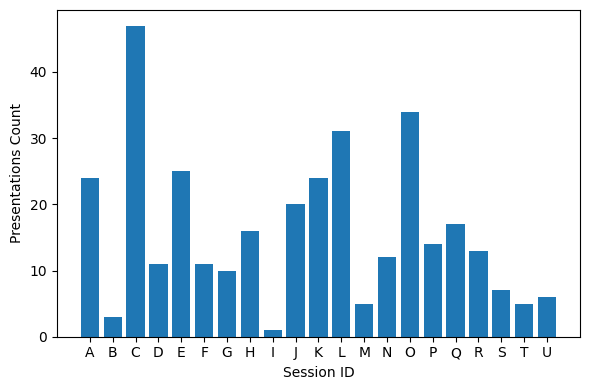

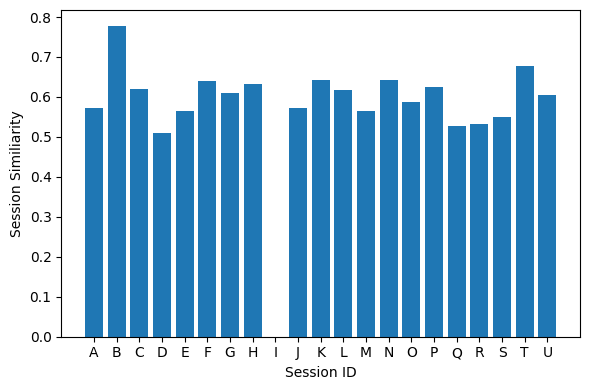

Are labels are the same?: True
The labels:
- **A:** Generative AI and Large Multimodal model for Agriculture & Natural Resources
- **B:** Cybersecurity, Social Impacts, and Risks of Emerging Information Systems
- **C:** Machine Vision for Precision Agriculture and Robotics
- **D:** Simulation-aided Agricultural Design and Optimization
- **E:** Spectroscopic Sensing and Imaging for Agriculture and Food Systems
- **F:** Unmanned Ground and Aerial Robots for Agricultural Applications
- **G:** Biosensors and Bioinstrumentation for One Health
- **H:** AI-Driven Tools and Technologies for High Throughput Phenotyping
- **I:** Soft and Tactile Robotics Applications in Agriculture and Natural Resources
- **J:** Machine Vision Applications in Agriculture and Food Processing
- **K:** Hyperspectral Imaging: Advances in Technologies, Analytics, and Applications
- **L:** 3D Machine Vision for Sensing and Automation
- **M:** Advanced Machine Vision Systems for Agricultural Applications (Peer-review s

In [12]:
import string

orig_session_names = list(original_analysis_results['session_sizes'].keys())
orig_session_sizes = list(original_analysis_results['session_sizes'].values())

def get_alpha_labels(n):
    """Generates alphabetical labels (A, B,..., Z, AA, AB,...)."""
    labels = []
    for i in range(n):
        label = ""
        temp = i
        while temp >= 0:
            remainder = temp % 26
            label = string.ascii_uppercase[remainder] + label
            temp = temp // 26 - 1
            if temp < -1: # Break after processing the last 'digit'
                break
        labels.append(label)
    return labels

orig_short_labels_alpha = get_alpha_labels(len(orig_session_names))

fig_size, ax_size = plt.subplots(figsize=(6, 4))
ax_size.bar(range(len(orig_session_names)), orig_session_sizes) 
ax_size.set_ylabel("Presentations Count")
ax_size.set_xlabel("Session ID") # Update x-axis label
ax_size.set_xticks(range(len(orig_session_names))) 
# Set the tick labels to be the alphabetical labels
ax_size.set_xticklabels(orig_short_labels_alpha) 
fig_size.tight_layout() 
plt.show()

label_mapping_alpha = {label: name for label, name in zip(orig_short_labels_alpha, orig_session_names)}
# for label, name in label_mapping_alpha.items():
#     print(f"- **{label}:** {name}")

orig_session_sim_names = list(original_analysis_results['similarity_values'].keys())
orig_session_sim = list(original_analysis_results['similarity_values'].values())

orig_short_labels_sim_alpha = get_alpha_labels(len(orig_session_sim_names))
# --- Create the Mapping for the Legend ---
label_mapping_alpha_sim = {label: name for label, name in zip(orig_short_labels_sim_alpha, orig_session_sim_names)}
fig_sim, ax_sim = plt.subplots(figsize=(6, 4))
ax_sim.bar(range(len(orig_session_sim_names)), orig_session_sim) 
ax_sim.set_ylabel("Session Similiarity")
ax_sim.set_xlabel("Session ID") # Update x-axis label
ax_sim.set_xticks(range(len(orig_session_sim_names))) 
# Set the tick labels to be the alphabetical labels
ax_sim.set_xticklabels(orig_short_labels_alpha) 
fig_sim.tight_layout() 
plt.show()
# for label, name in label_mapping_alpha_sim.items():
#     print(f"- **{label}:** {name}")

print(f"Are labels are the same?: {label_mapping_alpha == label_mapping_alpha_sim}")
print("The labels:")
for label, name in label_mapping_alpha.items():
    print(f"- **{label}:** {name}")


Presentations within a session should be more similar than the overall average between any two presentations.  How did the sessions created by the traditional process compare to the average between any two presentations?

In [13]:
print("Session Similarity values:")
for value in session_similarity.values():
    print(f"{value:.3f}")
# Calculate how many session similarity values are less than the average similarity
count_below_average = sum(1 for value in session_similarity.values() if value < average_similarity)
print(f"Number of session similarity values below the average similarity: {count_below_average}")

Session Similarity values:
0.619
0.632
0.588
0.565
0.549
0.609
0.527
0.779
0.532
0.573
0.643
0.625
0.573
0.620
0.678
0.605
0.643
0.511
0.000
0.566
0.641
Number of session similarity values below the average similarity: 4


# Linkage Matrix
Create a linkage matrix to visualize the dataset. This linkage matrix will also be used to build the new sessions.
This section creates diagrams of the entire dataset as well as a subset that illustrates challenges with cluster sizes not matching possible session sizes.

Color Threshold: 0.391


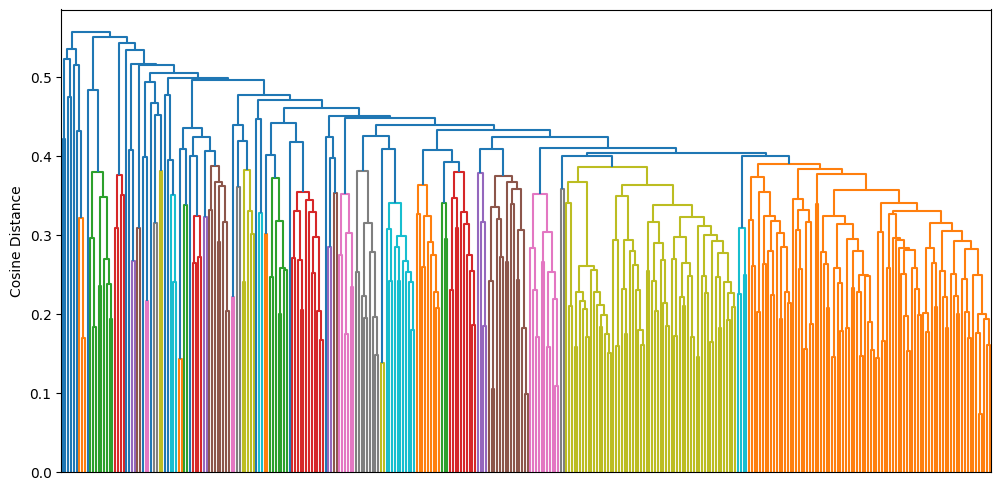

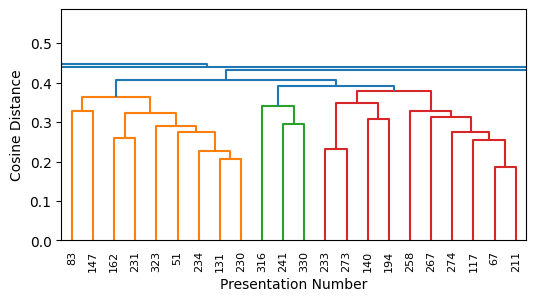

In [14]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(
    y=itsc_oral_embeddings_df,
    method='average',
    metric='cosine',
    )
color_threshold = 0.7 * max(linkage_matrix[:, 2])
print(f"Color Threshold: {color_threshold:.3f}")
# All Presentations sorted by count.
fig, ax = plt.subplots(figsize=(12, 6)) 
dn = dendrogram(
    linkage_matrix,
    count_sort='ascending',
    no_labels=True,
    ax=ax,
    )
ax.set_ylabel("Cosine Distance")

# Session cluster size example
fig, ax = plt.subplots(figsize=(6, 3)) 
dn = dendrogram(
    linkage_matrix,
    count_sort='ascending',
    no_labels=False,
    ax=ax,
    )
ax.set_ylabel("Cosine Distance")
ax.set_xlim(1280, 1500)
ax.set_xlabel("Presentation Number")
ax.tick_params(axis='x',labelsize=8)

Text(0, 0.5, 'Cosine Distance')

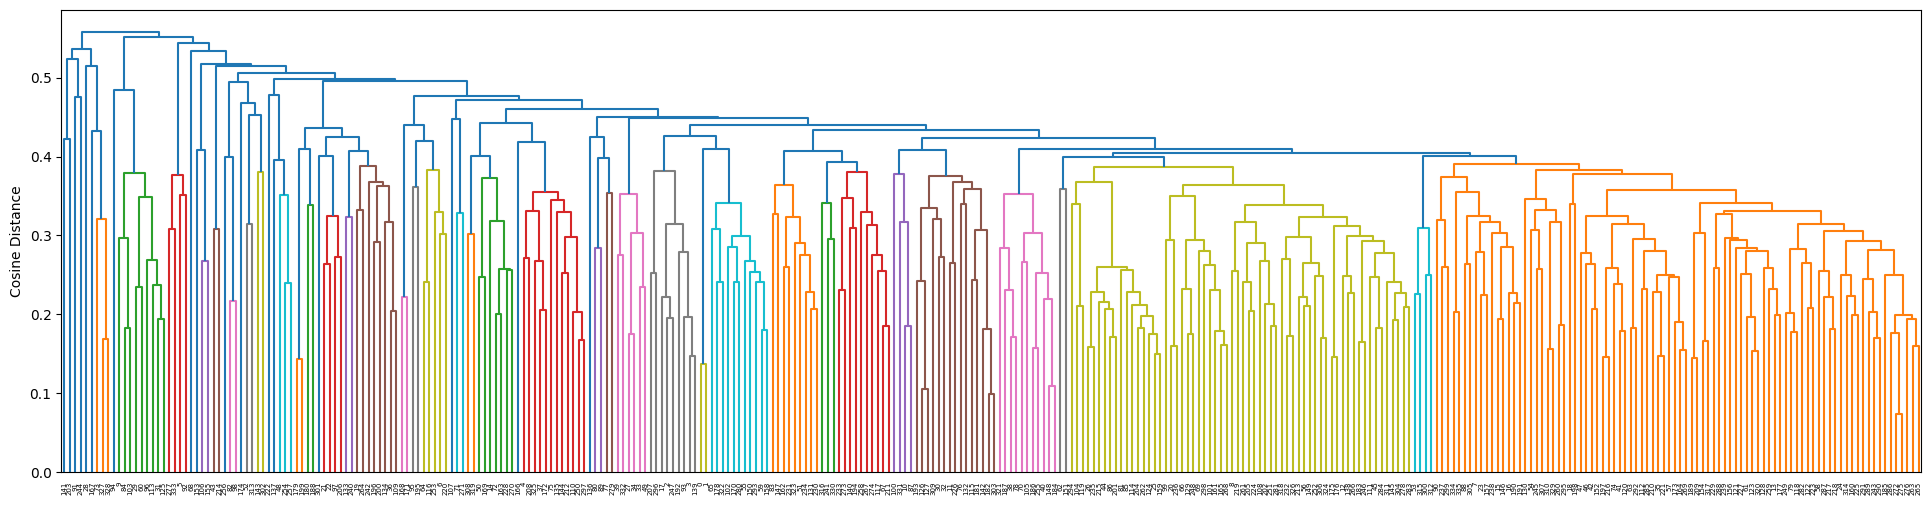

In [16]:
# Plot a very large dendrogram with all presentations labeled
fig, ax = plt.subplots(figsize=(24, 6)) 
dn = dendrogram(
    linkage_matrix,
    count_sort='ascending',
    ax=ax,
    )
ax.set_ylabel("Cosine Distance")

# Create Session Clusters
Session creation occurs using the linkage matrix

In [ ]:
# Create sessions using the agglomerative clustering linkage matrix. 
# Start merging with the most similar presentations (top of the linkage matrix).
# Once the clusters are at min_cluster_size, stop automatically merging.

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def extract_clusters(linkage_matrix, min_cluster_size, n_samples, similarities, tree_merge_stop=1, max_sessions=None):
    """
    Extracts clusters from a linkage matrix, ensuring no cluster is smaller than min_cluster_size.

    Args:
        linkage_matrix: The linkage matrix from scipy.cluster.hierarchy.linkage.
        min_cluster_size: The minimum number of samples in a cluster.
        n_samples: The total number of samples.
        similarities: The similarity matrix tensor.
        tree_merge_stop: The fraction of the tree to stop clustering at.
        max_sessions: Maximum number of sessions to create. If None, there is no limit.

    Returns:
        A list of lists, where each inner list represents a cluster and contains
        the indices of the samples belonging to that cluster.

    """

    final_nodes = []
    final_clusters = []
    unassigned_count = linkage_matrix[:,3].copy() # Number of unassigned clusters. All nodes start unassigned.
    unassigned_leaves = [[] for _ in range(linkage_matrix.shape[0])] # Leaves that have not yet been assigned to a final cluster.
    # Iterate through the linkage matrix (Linkage Matrix (begin -> end) goes bottom -> top on the dendrogram)
    # Process starts with the closest (most similar) nodes/clusters and works its way up the hierarchy.
    # Each row of the linkage matrix represents a merge of two clusters.
    # At each step, check the number of unassigned clusters (unassigned_count) for the two children of the current node.
    # If the number of unassigned clusters for either child is greater than min_cluster_size,
    # then we can create a final cluster (session).
    # If the number of unassigned clusters for both children is less than min_cluster_size,
    # leave them unassigned. Record the unassigned value as the amount remaining unassigned at that node.
    # Continue to the next row of the linkage matrix.

    for i in range(linkage_matrix.shape[0]):
        node_id = n_samples + i
        left_child, right_child = linkage_matrix[i, 0:2].astype(int)
        # Check children to update unassigned_count for this node
        if left_child >= n_samples:
            left_size = unassigned_count[left_child - n_samples]
            unassigned_leaves[i].extend(unassigned_leaves[left_child - n_samples])
        else:
            left_size = 1
            unassigned_leaves[i].append(left_child)
        if right_child >= n_samples:
            right_size = unassigned_count[right_child - n_samples]
            unassigned_leaves[i].extend(unassigned_leaves[right_child - n_samples])
        else:
            right_size = 1
            unassigned_leaves[i].append(right_child)
        unassigned_count[i] = left_size + right_size
        
        # Check if we have a final cluster, 
        # Also, stop making clusters once we are past a certain point in the linkage matrix.
        # Or, stop making clusters once we reach the maximum sessions.
        if unassigned_count[i] > min_cluster_size:
            # Check tree merge stop and max sessions conditions separately
            if i < linkage_matrix.shape[0] * tree_merge_stop:
                # Tree merge stop condition met; Check to make sure we are not at session cap.
                if max_sessions is None or len(final_clusters) < max_sessions:
                    # Under max sessions limit (or no limit)
                    create_cluster = True
                else:
                    create_cluster = False

            if create_cluster:
                # A final cluster has been found. All the presentations (unassigned leaves) in this node are assigned to it.
                final_nodes.append(node_id)
                final_clusters.append(unassigned_leaves[i])
                # Remove all presentations in this node from the unassigned_count.
                # When checked as a child of another node, it will report 0.
                unassigned_count[i] = 0
                unassigned_leaves[i] = []
    # Keep track of the presentations that were assigned in this final step.
    # They are the outliers and should probably be looked at closer.
    forced_merge = unassigned_leaves    
    # Try to merge any unassigned leaves into other clusters.
    # Since we stop merging at a certain point in the linkage matrix, we may have some unassigned leaves left over.
    # These are the leaves that were not assigned to any final cluster.
    # This does not check if the final clusters are too large.
    if unassigned_leaves[-1]:
        for leaf in unassigned_leaves[-1]:
            best_cluster_index = -1
            best_similarity = -1
            for i, cluster in enumerate(final_clusters):
                avg_similarity = similarities[leaf, cluster].mean().item()
                if avg_similarity > best_similarity:
                    best_similarity = avg_similarity
                    best_cluster_index = i
            if best_cluster_index > -1:
                final_clusters[best_cluster_index].append(leaf)
        unassigned_leaves[-1] = []

    return final_clusters, linkage_matrix, forced_merge, final_nodes

In [14]:
import pandas as pd

def process_clusters(clusters):
    """
    Processes a list of cluster indices to create a cluster dictionary and labels list.

    Args:
        clusters: A list of lists, where each inner list contains the indices
                        of items belonging to a cluster.

    Returns:
        A tuple containing:
            - cluster_dict: A dictionary where keys are cluster IDs (integers) and
                          values are lists of item indices belonging to that cluster.
            - labels: A list (or Pandas Series) where each element at index i
                      represents the cluster assignment of item i.
    """

    cluster_dict = {}
    labels = [None] * 810  # Initialize labels list with None values

    for cluster_id, cluster_indices in enumerate(clusters):
        cluster_dict[cluster_id] = cluster_indices
        for item_index in cluster_indices:
            labels[item_index] = cluster_id  # Assign cluster ID to the item index

    return cluster_dict, labels


For session creation, the number of sessions to create (21) ends up determining when the process stops creating new sessions. Based on prior experiments, if the number of sessions is not defined, it would be important to set a percentage of the tree at which to stop merging sessions. This is set to 95% based on this experimentation. If the process runs all the way to the top of the tree, it ends up forcing the merging of very different presentations. It is general better just to use these to fill in other sessions than to merge them into their own session.

In [18]:
min_cluster_size = 8
tree_merge_stop = .95
max_num_sessions = 21
session_indices, link_mat_final, outliers_merged, fnode_final = extract_clusters(linkage_matrix, 
                                                                                min_cluster_size, 
                                                                                n_samples=len(itsc_oral_similarities_tensor), 
                                                                                similarities=itsc_oral_similarities_tensor, 
                                                                                tree_merge_stop=tree_merge_stop, 
                                                                                max_sessions=max_num_sessions
                                                                                )
cluster_dict, labels = process_clusters(session_indices)
analysis_results_after_cluster = analyze_sessions(cluster_dict, itsc_oral_similarities_tensor.cpu().numpy())
print(f"Tree Merge Stop: {tree_merge_stop}")
print(f"Average Session Similarity: {analysis_results_after_cluster['avg_similarity']:.3f}")
print(f"Minimum Session Similarity: {analysis_results_after_cluster['min_session_similarity']:.3f}")
print(f"Number of Sessions: {analysis_results_after_cluster['num_sessions']}")
print(f"Number of sessions with more than 1 item: {analysis_results_after_cluster['clusters_gt1']}")
print(f"Presentations placed in sessions: {sum([len(s) for s in session_indices])}")


Tree Merge Stop: 0.95
Average Session Similarity: 0.638
Minimum Session Similarity: 0.600
Number of Sessions: 21
Number of sessions with more than 1 item: 21
Presentations placed in sessions: 336


### Save Session Number from Clustering to Presentation Dataframe

In [19]:
cluster_dict, labels = process_clusters(session_indices)
# Replace None values in the labels list with a default integer value (e.g., -1)
labels = [label if label is not None else -1 for label in labels]

# Assign the labels to the DataFrame and explicitly set the data type to int
itsc_oral_df['Clustering Session'] = pd.Series(labels, dtype='int')
# itsc_oral_df['Clustering Session'] = pd.Series(labels)
itsc_oral_df.to_pickle('itsc_clustered_presentations.pkl')
itsc_oral_df.to_csv('Clustering Sessioned Presentations.csv', index=True)

## Export for Web App

In [3]:
import pandas as pd
itsc_oral_df = pd.read_pickle('itsc_clustered_presentations.pkl')
itsc_oral_no_abstracts_df = itsc_oral_df.drop(columns=['Title and Abstract','Abstract'])
itsc_oral_no_abstracts_df.to_pickle('itsc_clustered_presentations_no_abstracts.pkl')

In [20]:
cluster_session_list, cluster_session_dict = create_session_index_lists(itsc_oral_df, session_column='Clustering Session')

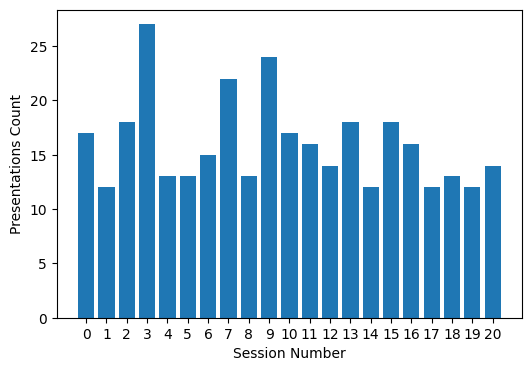

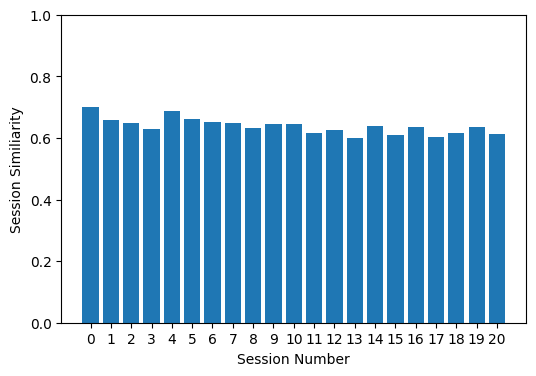

In [21]:
# Plot session size by session number - Repeated for copying into publications.
# st.subheader("Session Size Distribution - Clustered Sessions") 
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(analysis_results_after_cluster['session_sizes'].keys(), analysis_results_after_cluster['session_sizes'].values())
ax.set_ylabel("Presentations Count")
ax.set_xlabel("Session Number")
ax.set_xticks(list(analysis_results_after_cluster['session_sizes'].keys()))
ax.set_xticklabels([str(session) for session in analysis_results_after_cluster['session_sizes'].keys()])
plt.show()

# Plot session similarities
# st.subheader("Session Similarity Distribution - Clustered Sessions") 
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(analysis_results_after_cluster['similarity_values'].keys(), analysis_results_after_cluster['similarity_values'].values())
ax.set_ylabel("Session Similiarity")
ax.set_ylim(0, 1)
ax.set_xlabel("Session Number")
ax.set_xticks(list(analysis_results_after_cluster['similarity_values'].keys()))
ax.set_xticklabels([str(session) for session in analysis_results_after_cluster['similarity_values'].keys()])
plt.show()

# Creating Session Names and Keywords

In [29]:
# This code can be used to load the clustered presentations if processing starts at this point.
import pandas as pd
# Load the DataFrame from the pickle file
itsc_oral_df = pd.read_pickle('itsc_clustered_presentations.pkl')
itsc_oral_df['Clustering Session'] = itsc_oral_df['Clustering Session'].astype(int)  # Convert to integer type
import numpy as np
cluster_labels = itsc_oral_df['Clustering Session'].unique()
# Create a dict for the cluster indices
cluster_dict = itsc_oral_df.groupby('Clustering Session').indices
# Convert keys to integers because Pandas creates them as different types.
cluster_dict = {int(k): np.array(v, dtype=np.int64).tolist() for k, v in cluster_dict.items()}

In [30]:
sessions_dict = {}
for session_num, presentation_indices in cluster_dict.items():
    sessions_dict[session_num] = {"Indices": presentation_indices, "Presentations": []}
    for index in presentation_indices:
        try:
            title_abstract = itsc_oral_df.loc[index, "Title and Abstract"]
            sessions_dict[session_num]["Presentations"].append(title_abstract)
        except KeyError:
            print(f"Warning: Index {index} not found in oral_df for session {session_num}. Skipping.")
            continue # Skip the index if it's not present in the dataframe

## Gemini
### Full Example Titles and Keywords

In [25]:
import time

import os
from google import genai
from google.genai import types
from pydantic import BaseModel

# Support env variables from .env file if defined
import os
from dotenv import load_dotenv
env_path = load_dotenv('.env')
load_dotenv(env_path)

class Session_info(BaseModel):
    title_1: str
    title_2: str
    title_3: str
    keywords: str

start_time = time.time()
# Create the client
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
# Create titles
for session_key, session_value in sessions_dict.items():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "Please respond in this format\n\n "
                    "{"
                    "     'title_1': 'Robotic Vision and Actuation: Advancing Precision Weed Management in Agriculture',\n"
                    "     'title_2': 'AI-Driven Weed Control: From Smart Sprayers to Autonomous Robotics',\n"
                    "     'title_3': 'Next-Generation Weed Management: Integrating Deep Learning, Robotics, and Advanced Sensing',\n"
                    "     'keywords': 'Robotics, Machine Vision, Precision Agriculture, Weed Control, Artificial Intelligence'    }\n\n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    ),
            config={ # Constraint response to a specific schema
            'response_mime_type': 'application/json',
            'response_schema': Session_info,
        },

    )
    print(response.text)
    titles = response.text
    # Use instantiated objects.
    my_sessions: Session_info = response.parsed
    print(my_sessions)

    session_value['Gemini Ex Title 1'] = my_sessions.title_1
    session_value['Gemini Ex Title 2'] = my_sessions.title_2
    session_value['Gemini Ex Title 3'] = my_sessions.title_3
    session_value['Gemini Ex Keywords'] = my_sessions.keywords
end_time = time.time()
gemini_elapsed_time = end_time - start_time
print(f"Processing time: {gemini_elapsed_time:.4f} seconds")


{
  "title_1": "AI and Robotics for Sustainable Weed Management: Advancing Precision and Efficiency",
  "title_2": "Smart Weed Control: Innovations in Sensing, Robotics, and AI for Targeted Applications",
  "title_3": "Data-Driven Weed Management: Leveraging Machine Vision, Deep Learning, and Robotics",
  "keywords": "Weed Detection, Precision Agriculture, Robotics, Artificial Intelligence, Machine Vision"
}
title_1='AI and Robotics for Sustainable Weed Management: Advancing Precision and Efficiency' title_2='Smart Weed Control: Innovations in Sensing, Robotics, and AI for Targeted Applications' title_3='Data-Driven Weed Management: Leveraging Machine Vision, Deep Learning, and Robotics' keywords='Weed Detection, Precision Agriculture, Robotics, Artificial Intelligence, Machine Vision'
{
  "title_1": "3D Vision and Modeling for Plant Phenotyping: From Pixels to Insights",
  "title_2": "AI-Powered Analysis of Crop Traits: Revolutionizing Plant Measurement and Monitoring",
  "title_3": "

### Minimal Examples
Include the response form, but don't provide actual examples.

In [26]:
import time

import os
from google import genai
from google.genai import types
from pydantic import BaseModel

# Support env variables from .env file if defined
import os
from dotenv import load_dotenv
env_path = load_dotenv('.env')
load_dotenv(env_path)

class Session_info(BaseModel):
    title_1: str
    title_2: str
    title_3: str
    keywords: str

start_time = time.time()
# Create the client
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
# Create titles
for session_key, session_value in sessions_dict.items():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "Please respond in this format\n\n "
                    "{"
                    "     'title_1': 'Session Title',\n"
                    "     'title_2': 'Session Title',\n"
                    "     'title_3': 'Session Title',\n"
                    "     'keywords': 'keyword1, keyword2, keyword3, keyword4, keyword5'    }\n\n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    ),
            config={ # Constraint response to a specific schema
            'response_mime_type': 'application/json',
            'response_schema': Session_info,
        },

    )
    print(response.text)
    titles = response.text
    # Use instantiated objects.
    my_sessions: Session_info = response.parsed
    print(my_sessions)

    session_value['Gemini MinEx Title 1'] = my_sessions.title_1
    session_value['Gemini MinEx Title 2'] = my_sessions.title_2
    session_value['Gemini MinEx Title 3'] = my_sessions.title_3
    session_value['Gemini MinEx Keywords'] = my_sessions.keywords
end_time = time.time()
gemini_elapsed_time = end_time - start_time
print(f"Processing time: {gemini_elapsed_time:.4f} seconds")


{
"title_1": "AI-Powered Precision Weed Management: From Data to Deployment",
"title_2": "Deep Learning and Robotics for Sustainable Weed Control in Agriculture",
"title_3": "Advancements in Automated Weed Detection and Targeted Treatment Systems",
"keywords": "weed detection, precision spraying, deep learning, robotics, machine vision"
}
title_1='AI-Powered Precision Weed Management: From Data to Deployment' title_2='Deep Learning and Robotics for Sustainable Weed Control in Agriculture' title_3='Advancements in Automated Weed Detection and Targeted Treatment Systems' keywords='weed detection, precision spraying, deep learning, robotics, machine vision'
{
    "title_1": "3D Vision and Modeling for Agricultural Systems",
    "title_2": "Advanced Sensing and Digital Twins for Crop Phenotyping",
    "title_3": "Computational Modeling and Simulation in Agriculture",
    "keywords": "3D modeling, phenotyping, digital twin, simulation, agriculture"
}
title_1='3D Vision and Modeling for Agri

### No Example
Do not provide a response form example at all. Just rely on the prompt controls.

In [27]:
import time

import os
from google import genai
from google.genai import types
from pydantic import BaseModel

# Support env variables from .env file if defined
import os
from dotenv import load_dotenv
env_path = load_dotenv('.env')
load_dotenv(env_path)

class Session_info(BaseModel):
    title_1: str
    title_2: str
    title_3: str
    keywords: str

start_time = time.time()
# Create the client
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
# Create titles
for session_key, session_value in sessions_dict.items():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    ),
            config={ # Constraint response to a specific schema
            'response_mime_type': 'application/json',
            'response_schema': Session_info,
        },

    )
    print(response.text)
    titles = response.text
    # Use instantiated objects.
    my_sessions: Session_info = response.parsed
    print(my_sessions)

    session_value['Gemini NoEx Title 1'] = my_sessions.title_1
    session_value['Gemini NoEx Title 2'] = my_sessions.title_2
    session_value['Gemini NoEx Title 3'] = my_sessions.title_3
    session_value['Gemini NoEx Keywords'] = my_sessions.keywords
end_time = time.time()
gemini_elapsed_time = end_time - start_time
print(f"Processing time: {gemini_elapsed_time:.4f} seconds")


{
  "title_1": "AI-Driven Precision Weed Management: From Data to Deployment",
  "title_2": "Robotics and Machine Vision for Sustainable Weed Control",
  "title_3": "Advancements in Automated Weed Detection and Targeted Treatment",
  "keywords": "weed detection, machine vision, robotics, precision agriculture, deep learning"
}
title_1='AI-Driven Precision Weed Management: From Data to Deployment' title_2='Robotics and Machine Vision for Sustainable Weed Control' title_3='Advancements in Automated Weed Detection and Targeted Treatment' keywords='weed detection, machine vision, robotics, precision agriculture, deep learning'
{
  "title_1": "Advanced 3D Modeling and Simulation Techniques for Agricultural Systems",
  "title_2": "Sensing, Modeling, and Simulation of Biological and Agricultural Systems using Novel 3D Techniques",
  "title_3": "Digital Twins and Advanced Modeling for Agricultural and Biological Systems",
  "keywords": "3D modeling, simulation, digital twin, phenotyping, agric

### Save the Gemini Results

In [29]:
df_sessions = pd.DataFrame.from_dict(sessions_dict, orient='index')
df_sessions.to_csv('Gemini_sessions.csv', index=True)
import pickle
df_sessions.to_pickle('AI_sessions.pkl')
with open("AI_sessions_dict.pkl", "wb") as f:
    pickle.dump(sessions_dict, f) 


In [ ]:
## Load pickled sessions dictionary for continuing.
# import pickle

# with open("AI_sessions_dict.pkl", "rb") as f:
#     sessions_dict = pickle.load(f) 

## Llama 3.2 Local
Running Llama locally can take a long time. It may be a good idea to save to the harddrive at each step.

In [30]:
import llama_cpp
model = llama_cpp.Llama(
    model_path="llama-3.2-3b-instruct-q8_0.gguf",
    n_ctx=0,
    n_gpu_layers=-1,  # Use all available GPU layers (if any) or CPU (if no GPU is available
    )

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA RTX 500 Ada Generation Laptop GPU, compute capability 8.9, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (NVIDIA RTX 500 Ada Generation Laptop GPU) - 3243 MiB free
llama_model_loader: loaded meta data with 30 key-value pairs and 255 tensors from llama-3.2-3b-instruct-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Llama 3.2 3B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4

In [ ]:
# Used to create a smaller dictionary for testing

small_session_dict = dict(list(sessions_dict.items())[:1])

### Full Example Titles and Keywords

In [31]:
import json
import time

start_time = time.time()
# Iterate over the sessions and prompt the LLM for the session title and keywords
for session_key, session_value in sessions_dict.items():# sessions_dict.items():
    messages=[
    {   "role": "user", 
        "content": ("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "Please respond in this format\n\n "
                    "{"
                    "     'title_1': 'Robotic Vision and Actuation: Advancing Precision Weed Management in Agriculture',\n"
                    "     'title_2': 'AI-Driven Weed Control: From Smart Sprayers to Autonomous Robotics',\n"
                    "     'title_3': 'Next-Generation Weed Management: Integrating Deep Learning, Robotics, and Advanced Sensing',\n"
                    "     'keywords': 'Robotics, Machine Vision, Precision Agriculture, Weed Control, Artificial Intelligence'    }\n\n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    )
    },]
    session_titleAbsLlama = (model.create_chat_completion(
        messages=messages,
        response_format={
        "type": "json_object",
        "schema": {
            "type": "object",
            "properties": {"title1": {"type": "string"}, "title2": {"type": "string"}, "title3": {"type": "string"}, "keywords": {"type": "string"}},
            "required": ["title1", "title2", "title3", "keywords"],
            },
        },
    ))
    text_answer = session_titleAbsLlama['choices'][0]['message']['content']
    print(text_answer)

    try:
        # Parse the JSON string into a Python dictionary
        answer_dict = json.loads(text_answer)

        # Access the values using the dictionary keys
        title_1 = answer_dict['title1']
        title_2 = answer_dict['title2']
        title_3 = answer_dict['title3']
        keywords = answer_dict['keywords']

        # Now you can save the titles and keywords
        session_value['Llama Ex Title 1'] = title_1
        session_value['Llama Ex Title 2'] = title_2
        session_value['Llama Ex Title 3'] = title_3
        session_value['Llama Ex Keywords'] = keywords

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print(f"Problematic JSON string: {text_answer}")
        # Handle the error appropriately, e.g., set default values or skip the session
        session_value['Llama Ex Title 1'] = "Error: Could not generate title"
        session_value['Llama Ex Title 2'] = "Error: Could not generate title"
        session_value['Llama Ex Title 3'] = "Error: Could not generate title"
        session_value['Llama Ex Keywords'] = "Error: Could not generate keywords"
end_time = time.time()
llama_elapsed_time = end_time - start_time
print(f"Processing time: {llama_elapsed_time:.4f} seconds")

llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  102150.10 ms /  7550 tokens (   13.53 ms per token,    73.91 tokens per second)
llama_perf_context_print:        eval time =   47263.05 ms /    85 runs   (  556.04 ms per token,     1.80 tokens per second)
llama_perf_context_print:       total time =  150895.20 ms /  7635 tokens
Llama.generate: 198 prefix-match hit, remaining 4505 prompt tokens to eval


{ "title1": "Precision Weed Management: Advances in Robotics, Machine Vision, and Deep Learning", "title2": "Weed Control 2.0: Integrating Robotics, AI, and Precision Agriculture", "title3": "Next-Generation Weed Management: A Multidisciplinary Approach to Precision Agriculture", "keywords": "Robotics, Machine Vision, Precision Agriculture, Weed Control, Artificial Intelligence" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   46922.72 ms /  4505 tokens (   10.42 ms per token,    96.01 tokens per second)
llama_perf_context_print:        eval time =   41232.47 ms /   110 runs   (  374.84 ms per token,     2.67 tokens per second)
llama_perf_context_print:       total time =   89974.36 ms /  4615 tokens
Llama.generate: 198 prefix-match hit, remaining 6398 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture: Integration of Robotics, Machine Learning, and Sensing Technologies for Efficient Crop Management", "title2": "Precision Agriculture 2.0: Leveraging Robotics, AI, and Sensing for Optimal Crop Yield and Resource Allocation", "title3": "Next-Generation Precision Agriculture: Combining Robotics, Deep Learning, and Advanced Sensing for Intelligent Crop Management", "keywords": "Robotics, Machine Learning, Precision Agriculture, Sensing Technologies, Crop Management, AI, Deep Learning" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   79954.55 ms /  6398 tokens (   12.50 ms per token,    80.02 tokens per second)
llama_perf_context_print:        eval time =   47047.59 ms /    95 runs   (  495.24 ms per token,     2.02 tokens per second)
llama_perf_context_print:       total time =  128905.08 ms /  6493 tokens
Llama.generate: 198 prefix-match hit, remaining 10383 prompt tokens to eval


{ "title1": "Precision Agriculture for Sustainable Crop Management: Integrating Remote Sensing, Machine Learning, and Robotics", "title2": "Advancing Crop Management through AI-Driven Decision Making: A Multidisciplinary Approach", "title3": "Next-Generation Crop Management: Leveraging Remote Sensing, Machine Learning, and Robotics for Sustainable Agriculture", "keywords": "Remote Sensing, Machine Learning, Precision Agriculture, Crop Management, Sustainable Agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  181885.27 ms / 10383 tokens (   17.52 ms per token,    57.09 tokens per second)
llama_perf_context_print:        eval time =   86313.55 ms /   113 runs   (  763.84 ms per token,     1.31 tokens per second)
llama_perf_context_print:       total time =  270698.12 ms / 10496 tokens
Llama.generate: 198 prefix-match hit, remaining 5601 prompt tokens to eval


{ "title1": "Robotic Vision and Actuation: Advancing Precision Agriculture in the Era of Artificial Intelligence and Robotics", "title2": "Precision Agriculture 2.0: Integrating AI, Robotics, and Hyperspectral Imaging for Optimal Crop Yield and Resource Management", "title3": "Next-Generation Precision Agriculture: Leveraging Deep Learning, Robotics, and Hyperspectral Imaging for Enhanced Crop Monitoring and Management", "keywords": "Robotics, Machine Vision, Precision Agriculture, Hyperspectral Imaging, Artificial Intelligence, Deep Learning" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   64790.16 ms /  5601 tokens (   11.57 ms per token,    86.45 tokens per second)
llama_perf_context_print:        eval time =   42764.18 ms /    96 runs   (  445.46 ms per token,     2.24 tokens per second)
llama_perf_context_print:       total time =  109549.78 ms /  5697 tokens
Llama.generate: 198 prefix-match hit, remaining 4928 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture: Integration of Robotics, AI, and Multivariable Data", "title2": "Robotic Vision and Actuation for Autonomous Crop Monitoring and Phenotyping", "title3": "Next-Generation Precision Agriculture: Integrating Deep Learning, Robotics, and Advanced Sensing", "keywords": "Robotics, Machine Vision, Precision Agriculture, Multivariable Data, Artificial Intelligence, Autonomous Systems, Sensor Fusion, Deep Learning" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   53730.41 ms /  4928 tokens (   10.90 ms per token,    91.72 tokens per second)
llama_perf_context_print:        eval time =   40280.14 ms /   100 runs   (  402.80 ms per token,     2.48 tokens per second)
llama_perf_context_print:       total time =   96076.40 ms /  5028 tokens
Llama.generate: 198 prefix-match hit, remaining 5705 prompt tokens to eval


{ "title1": "Precision Agriculture for Sustainable Strawberry Production: Advances in Robotics, Sensing, and AI", "title2": "Strawberry Harvesting Automation: Leveraging Robotics, Computer Vision, and Machine Learning", "title3": "Next-Generation Strawberry Production: Integrating Robotics, Sensing, and Artificial Intelligence for Optimal Yield and Sustainability", "keywords": "Robotics, Precision Agriculture, Artificial Intelligence, Computer Vision, Machine Learning, Sustainable Agriculture, Strawberry Production" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   66786.43 ms /  5705 tokens (   11.71 ms per token,    85.42 tokens per second)
llama_perf_context_print:        eval time =   45663.86 ms /   101 runs   (  452.12 ms per token,     2.21 tokens per second)
llama_perf_context_print:       total time =  114491.53 ms /  5806 tokens
Llama.generate: 198 prefix-match hit, remaining 7947 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture: Integration of Robotics, AI, and Sensing Technologies", "title2": "Precision Agriculture 2.0: Harnessing AI, Robotics, and Sensing for Enhanced Crop Yield and Sustainability", "title3": "Next-Generation Precision Agriculture: Leveraging AI, Robotics, and Advanced Sensing for Optimized Crop Management", "keywords": "Robotics, Artificial Intelligence, Precision Agriculture, Sensing Technologies, Machine Vision, Autonomous Systems" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  115706.13 ms /  7947 tokens (   14.56 ms per token,    68.68 tokens per second)
llama_perf_context_print:        eval time =   53828.60 ms /    90 runs   (  598.10 ms per token,     1.67 tokens per second)
llama_perf_context_print:       total time =  171451.81 ms /  8037 tokens
Llama.generate: 198 prefix-match hit, remaining 3456 prompt tokens to eval


{ "title1": "Precision Agriculture through Robotics and AI: Advancing Crop Management and Sustainability", "title2": "Robotic Vision and Actuation: Advancing Precision Weed Management in Agriculture", "title3": "Next-Generation Crop Monitoring: Integrating Deep Learning, Robotics, and Advanced Sensing for Sustainable Agriculture" , "keywords": "Robotics, Machine Vision, Precision Agriculture, Crop Monitoring, Artificial Intelligence, Deep Learning" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   31317.46 ms /  3456 tokens (    9.06 ms per token,   110.35 tokens per second)
llama_perf_context_print:        eval time =   27209.50 ms /    88 runs   (  309.20 ms per token,     3.23 tokens per second)
llama_perf_context_print:       total time =   60292.53 ms /  3544 tokens
Llama.generate: 197 prefix-match hit, remaining 8930 prompt tokens to eval


{ "title1": "Precision Agriculture and Autonomous Robotics: Advancing Sustainable Farming Practices", "title2": "Autonomous Farming Systems: Integrating Robotics, AI, and Sensing Technologies", "title3": "Next-Generation Precision Agriculture: Leveraging Robotics, AI, and IoT for Sustainable Farming", "keywords": "Autonomous Robotics, Precision Agriculture, Artificial Intelligence, Internet of Things, Sensing Technologies" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  140194.90 ms /  8930 tokens (   15.70 ms per token,    63.70 tokens per second)
llama_perf_context_print:        eval time =   60024.17 ms /    91 runs   (  659.61 ms per token,     1.52 tokens per second)
llama_perf_context_print:       total time =  202161.35 ms /  9021 tokens
Llama.generate: 197 prefix-match hit, remaining 7232 prompt tokens to eval


{ "title1": "Precision Agriculture for Pest Management: Advances in Robotics, AI, and Sensing", "title2": "Next-Generation Pest Management: Integrating Deep Learning, Robotics, and Advanced Sensing", "title3": "Automated Pest Detection and Management: A Synergistic Approach to Precision Agriculture", "keywords": "Precision Agriculture, Robotics, Artificial Intelligence, Sensing, Pest Management, Autonomous Systems, Machine Learning" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   98287.88 ms /  7232 tokens (   13.59 ms per token,    73.58 tokens per second)
llama_perf_context_print:        eval time =   53766.90 ms /    98 runs   (  548.64 ms per token,     1.82 tokens per second)
llama_perf_context_print:       total time =  154188.58 ms /  7330 tokens
Llama.generate: 198 prefix-match hit, remaining 5665 prompt tokens to eval


{ "title1": "Precision Agriculture for Sustainable Crop Management: Advances in Robotics, AI, and Sensing Technologies", "title2": "Next-Generation Precision Agriculture: Integrating Robotics, AI, and Sensing for Enhanced Crop Management", "title3": "Precision Agriculture 2.0: Leveraging Robotics, AI, and Sensing Technologies for Sustainable Crop Management", "keywords": "Robotics, Precision Agriculture, Artificial Intelligence, Sensing Technologies, Sustainable Crop Management" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   66357.80 ms /  5665 tokens (   11.71 ms per token,    85.37 tokens per second)
llama_perf_context_print:        eval time =   35466.99 ms /    79 runs   (  448.95 ms per token,     2.23 tokens per second)
llama_perf_context_print:       total time =  103427.96 ms /  5744 tokens
Llama.generate: 198 prefix-match hit, remaining 5508 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture through Deep Learning and Robotics", "title2": "Robotic Vision and Actuation: Advancing Precision Weed Management in Agriculture", "title3": "Next-Generation Weed Management: Integrating Deep Learning, Robotics, and Advanced Sensing", "keywords": "Robotics, Machine Vision, Precision Agriculture, Weed Control, Artificial Intelligence" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   64121.12 ms /  5508 tokens (   11.64 ms per token,    85.90 tokens per second)
llama_perf_context_print:        eval time =   44835.11 ms /   102 runs   (  439.56 ms per token,     2.28 tokens per second)
llama_perf_context_print:       total time =  111159.42 ms /  5610 tokens
Llama.generate: 198 prefix-match hit, remaining 8242 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture: Integrating Robotics, AI, and Sensing Technologies for Sustainable Cotton Production", "title2": "Precision Cotton Management: Exploring the Potential of Robotics, Machine Learning, and Sensing Technologies", "title3": "Cotton Production 4.0: Harnessing the Power of AI, Robotics, and Sensing Technologies for Enhanced Sustainability and Yield", "keywords": "Robotics, Machine Learning, Precision Agriculture, Cotton Production, Sustainable Agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  122348.21 ms /  8242 tokens (   14.84 ms per token,    67.37 tokens per second)
llama_perf_context_print:        eval time =   55401.23 ms /    90 runs   (  615.57 ms per token,     1.62 tokens per second)
llama_perf_context_print:       total time =  179708.87 ms /  8332 tokens
Llama.generate: 198 prefix-match hit, remaining 3897 prompt tokens to eval


{ "title1": "Precision Livestock Monitoring and Management: Leveraging AI and IoT Technologies", "title2": "Automating Livestock Monitoring and Management: A Review of Recent Advances", "title3": "Next-Generation Livestock Monitoring: Integrating AI, IoT, and Precision Agriculture", "keywords": "Artificial Intelligence, Internet of Things, Precision Agriculture, Livestock Monitoring, Animal Welfare, Sustainability" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   37339.62 ms /  3897 tokens (    9.58 ms per token,   104.37 tokens per second)
llama_perf_context_print:        eval time =   29713.83 ms /    88 runs   (  337.66 ms per token,     2.96 tokens per second)
llama_perf_context_print:       total time =   68795.94 ms /  3985 tokens
Llama.generate: 198 prefix-match hit, remaining 6417 prompt tokens to eval


{ "title1": "Precision Agriculture for Sustainable Crop Production: Advances in IoT, Robotics, and AI", "title2": "Integrating Robotics, AI, and IoT for Precision Agriculture: Opportunities and Challenges", "title3": "Next-Generation Precision Agriculture: Leveraging Robotics, AI, and IoT for Enhanced Crop Yield and Sustainability", "keywords": "Precision Agriculture, IoT, Robotics, AI, Sustainable Crop Production" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   80851.27 ms /  6417 tokens (   12.60 ms per token,    79.37 tokens per second)
llama_perf_context_print:        eval time =   50795.51 ms /   102 runs   (  498.00 ms per token,     2.01 tokens per second)
llama_perf_context_print:       total time =  134885.49 ms /  6519 tokens
Llama.generate: 198 prefix-match hit, remaining 6196 prompt tokens to eval


{ "title1": "Precision Agriculture: Advancing Robotics, Machine Learning, and Sensing for Sustainable Crop Management", "title2": "Intelligent Farming: Integrating Robotics, AI, and Sensing for Enhanced Crop Yield and Quality", "title3": "Next-Generation Agricultural Robotics: Combining Deep Learning, Sensing, and Automation for Precision Farming" , "keywords": "Robotics, Machine Learning, Precision Agriculture, Sensing, Automation, Artificial Intelligence" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   75887.43 ms /  6196 tokens (   12.25 ms per token,    81.65 tokens per second)
llama_perf_context_print:        eval time =   52125.84 ms /   108 runs   (  482.65 ms per token,     2.07 tokens per second)
llama_perf_context_print:       total time =  130269.99 ms /  6304 tokens
Llama.generate: 198 prefix-match hit, remaining 5509 prompt tokens to eval


{ "title1": "Precision Agriculture for Sustainable Crop Management: Integrating Robotics, AI, and Sensing Technologies", "title2": "Next-Generation Crop Management: Leveraging Robotics, Multispectral Imaging, and Deep Learning", "title3": "Advancing Precision Agriculture: A Multi-Disciplinary Approach to Crop Management and Sustainability", "keywords": "Precision Agriculture, Robotics, Multispectral Imaging, Deep Learning, AI, Sensing Technologies, Sustainable Crop Management, Crop Yield, Water Use Efficiency, Soil Health" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   64140.18 ms /  5509 tokens (   11.64 ms per token,    85.89 tokens per second)
llama_perf_context_print:        eval time =   47022.75 ms /   107 runs   (  439.46 ms per token,     2.28 tokens per second)
llama_perf_context_print:       total time =  113450.61 ms /  5616 tokens
Llama.generate: 198 prefix-match hit, remaining 4641 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture: Integrating Deep Learning, Robotics, and Advanced Sensing for Sustainable Crop Management", "title2": "Precision Agriculture 2.0: Leveraging AI, Robotics, and IoT for Enhanced Crop Yield and Resource Efficiency", "title3": "Smart Farming: Exploring the Intersection of Deep Learning, Robotics, and Advanced Sensing for Optimized Crop Management", "keywords": "Artificial Intelligence, Robotics, Precision Agriculture, Deep Learning, IoT, Sensing Technologies" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   49014.43 ms /  4641 tokens (   10.56 ms per token,    94.69 tokens per second)
llama_perf_context_print:        eval time =   34486.65 ms /    90 runs   (  383.19 ms per token,     2.61 tokens per second)
llama_perf_context_print:       total time =   85363.21 ms /  4731 tokens
Llama.generate: 198 prefix-match hit, remaining 4368 prompt tokens to eval


{ "title1": "Precision Agriculture and Autonomous Systems: Advancing Sustainable Crop Management through Robotics and AI", "title2": "Integrating Robotics, AI, and Precision Agriculture for Efficient Crop Management", "title3": "Next-Generation Precision Agriculture: Harnessing Robotics, AI, and Advanced Sensing for Sustainable Crop Management", "keywords": "Robotics, Precision Agriculture, Artificial Intelligence, Autonomous Systems, Sustainable Crop Management" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   44506.52 ms /  4368 tokens (   10.19 ms per token,    98.14 tokens per second)
llama_perf_context_print:        eval time =   38147.83 ms /   104 runs   (  366.81 ms per token,     2.73 tokens per second)
llama_perf_context_print:       total time =   84753.62 ms /  4472 tokens
Llama.generate: 198 prefix-match hit, remaining 5685 prompt tokens to eval


{ "title1": "Integrating AI and Robotics for Precision Agriculture: A Multi-Disciplinary Approach to Enhancing Crop Yields and Sustainability", "title2": "Next-Generation Precision Agriculture: Leveraging AI, Robotics, and IoT for Increased Efficiency and Sustainability", "title3": "Precision Agriculture 2.0: AI-Driven Decision Making and Robotics for Enhanced Crop Yields and Environmental Sustainability", "keywords": "Artificial Intelligence, Robotics, Precision Agriculture, Internet of Things, Sustainability" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   66531.67 ms /  5685 tokens (   11.70 ms per token,    85.45 tokens per second)
llama_perf_context_print:        eval time =   41503.69 ms /    92 runs   (  451.13 ms per token,     2.22 tokens per second)
llama_perf_context_print:       total time =  109862.80 ms /  5777 tokens


{ "title1": "Advancing Precision Agriculture with AI and Robotics: A Multidisciplinary Approach", "title2": "Integrating AI, Robotics, and Sensing for Next-Generation Precision Agriculture", "title3": "Precision Agriculture 2.0: Leveraging AI, Robotics, and IoT for Sustainable Farming", "keywords": "Artificial Intelligence, Robotics, Precision Agriculture, Internet of Things, Sustainable Farming" }
Processing time: 2670.5897 seconds


#### Save Current Titles

In [32]:
df_sessions = pd.DataFrame.from_dict(sessions_dict, orient='index')
df_sessions.to_csv('Gemini_Llama_sessions.csv', index=True)
import pickle
df_sessions.to_pickle('AI_sessions.pkl')
with open("AI_sessions_dict.pkl", "wb") as f:
    pickle.dump(sessions_dict, f) 

### Minimal Examples
Include the response form, but don't provide actual examples.

In [33]:
import json
import time

start_time = time.time()
# Iterate over the sessions and prompt the LLM for the session title and keywords
for session_key, session_value in sessions_dict.items():
    messages=[
    {   "role": "user", 
        "content": ("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "Please respond in this format\n\n "
                    "{"
                    "     'title_1': 'Session Title',\n"
                    "     'title_2': 'Session Title',\n"
                    "     'title_3': 'Session Title',\n"
                    "     'keywords': 'keyword1, keyword2, keyword3, keyword4, keyword5'    }\n\n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    )
    },]
    session_titleAbsLlama = (model.create_chat_completion(
        messages=messages,
        response_format={
        "type": "json_object",
        "schema": {
            "type": "object",
            "properties": {"title1": {"type": "string"}, "title2": {"type": "string"}, "title3": {"type": "string"}, "keywords": {"type": "string"}},
            "required": ["title1", "title2", "title3", "keywords"],
            },
        },
    ))
    text_answer = session_titleAbsLlama['choices'][0]['message']['content']
    print(text_answer)

    try:
        # Parse the JSON string into a Python dictionary
        answer_dict = json.loads(text_answer)

        # Access the values using the dictionary keys
        title_1 = answer_dict['title1']
        title_2 = answer_dict['title2']
        title_3 = answer_dict['title3']
        keywords = answer_dict['keywords']

        # Now you can save the titles and keywords
        session_value['Llama MinEx Title 1'] = title_1
        session_value['Llama MinEx Title 2'] = title_2
        session_value['Llama MinEx Title 3'] = title_3
        session_value['Llama MinEx Keywords'] = keywords

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print(f"Problematic JSON string: {text_answer}")
        # Handle the error appropriately, e.g., set default values or skip the session
        session_value['Llama MinEx Title 1'] = "Error: Could not generate title"
        session_value['Llama MinEx Title 2'] = "Error: Could not generate title"
        session_value['Llama MinEx Title 3'] = "Error: Could not generate title"
        session_value['Llama MinEx Keywords'] = "Error: Could not generate keywords"
end_time = time.time()
llama_elapsed_time = end_time - start_time
print(f"Processing time: {llama_elapsed_time:.4f} seconds")

Llama.generate: 101 prefix-match hit, remaining 7411 prompt tokens to eval
llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   98481.51 ms /  7411 tokens (   13.29 ms per token,    75.25 tokens per second)
llama_perf_context_print:        eval time =   37572.60 ms /    68 runs   (  552.54 ms per token,     1.81 tokens per second)
llama_perf_context_print:       total time =  137424.71 ms /  7479 tokens
Llama.generate: 160 prefix-match hit, remaining 4505 prompt tokens to eval


{ "title1": "Precision Weed Management through Deep Learning and Robotics", "title2": "Automated Weed Detection and Control using Machine Vision and AI", "title3": "Sustainable Agriculture through Robotics and Computer Vision", "keywords": "weed detection, machine vision, deep learning, robotics, precision agriculture, sustainable farming" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   46483.25 ms /  4505 tokens (   10.32 ms per token,    96.92 tokens per second)
llama_perf_context_print:        eval time =   32827.19 ms /    88 runs   (  373.04 ms per token,     2.68 tokens per second)
llama_perf_context_print:       total time =   81060.30 ms /  4593 tokens
Llama.generate: 160 prefix-match hit, remaining 6398 prompt tokens to eval


{ "title1": "Advances in Agricultural 3D Reconstruction and Phenotyping", "title2": "3D Reconstruction and Phenotyping in Agriculture and Food Processing", "title3": "Digital Twins for Agricultural Engineering and Food Processing", "keywords": "3D reconstruction, phenotyping, agriculture, digital twins, agricultural engineering, food processing, precision agriculture, crop monitoring, plant architecture, soil dynamics, particulate flow" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   79150.96 ms /  6398 tokens (   12.37 ms per token,    80.83 tokens per second)
llama_perf_context_print:        eval time =   36411.88 ms /    74 runs   (  492.05 ms per token,     2.03 tokens per second)
llama_perf_context_print:       total time =  117141.39 ms /  6472 tokens
Llama.generate: 160 prefix-match hit, remaining 10383 prompt tokens to eval


{ "title1": "Precision Agriculture through Satellite Remote Sensing and AI Integration", "title2": "Soil Health Monitoring and Management using Satellite and Machine Learning", "title3": "Crop Yield Prediction and Management using Satellite Imagery and AI", "keywords": "satellite remote sensing, machine learning, precision agriculture, soil health, crop yield prediction" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  180154.33 ms / 10383 tokens (   17.35 ms per token,    57.63 tokens per second)
llama_perf_context_print:        eval time =   67099.20 ms /    88 runs   (  762.49 ms per token,     1.31 tokens per second)
llama_perf_context_print:       total time =  249152.46 ms / 10471 tokens
Llama.generate: 160 prefix-match hit, remaining 5601 prompt tokens to eval


{ "title1": "Hyperspectral Imaging for Precision Agriculture: A Multidisciplinary Approach", "title2": "Non-Destructive Crop Monitoring using Hyperspectral Imaging", "title3": "Precision Agriculture with Hyperspectral Imaging: A Review of Current Methods and Future Directions", "keywords": "hyperspectral imaging, precision agriculture, crop monitoring, non-destructive testing, machine learning, spectral analysis" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   64330.66 ms /  5601 tokens (   11.49 ms per token,    87.07 tokens per second)
llama_perf_context_print:        eval time =   40769.83 ms /    92 runs   (  443.15 ms per token,     2.26 tokens per second)
llama_perf_context_print:       total time =  106990.06 ms /  5693 tokens
Llama.generate: 160 prefix-match hit, remaining 4928 prompt tokens to eval


{ "title1": "Precision Agriculture: Advances in Multi-Sensor Fusion and Autonomous Navigation", "title2": "Enhancing Crop Monitoring and Yield Prediction through Inertial Measurement Unit-based Systems", "title3": "Autonomous Robotic Navigation for Sustainable Agriculture: A Multi-Disciplinary Approach", "keywords": "Autonomous Navigation, Multi-Sensor Fusion, Precision Agriculture, Inertial Measurement Unit, Robotics, Computer Vision, Machine Learning" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   53215.00 ms /  4928 tokens (   10.80 ms per token,    92.61 tokens per second)
llama_perf_context_print:        eval time =   33979.00 ms /    85 runs   (  399.75 ms per token,     2.50 tokens per second)
llama_perf_context_print:       total time =   88868.02 ms /  5013 tokens
Llama.generate: 160 prefix-match hit, remaining 5705 prompt tokens to eval


{ "title1": "AI-Driven Insights for Sustainable Strawberry Production: Exploring Multimodal Data and Predictive Models", "title2": "Optimizing Strawberry Greenhouse Environments with AI-Driven Control Systems", "title3": "Predicting Strawberry Yield and Quality with Transfer Learning-Based Models", "keywords": "Artificial Intelligence, Machine Learning, Sustainable Agriculture, Strawberry Production, Greenhouse Optimization" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   66181.75 ms /  5705 tokens (   11.60 ms per token,    86.20 tokens per second)
llama_perf_context_print:        eval time =   34082.07 ms /    76 runs   (  448.45 ms per token,     2.23 tokens per second)
llama_perf_context_print:       total time =  101877.27 ms /  5781 tokens
Llama.generate: 160 prefix-match hit, remaining 7947 prompt tokens to eval


{ "title1": "Autonomous Harvesting: Advances in Robotics and Computer Vision", "title2": "Precision Agriculture: Robotics and Computer Vision Applications", "title3": "Harvesting and Pruning: Robotics and Computer Vision Innovations", "keywords": "robotic harvesting, computer vision, precision agriculture, autonomous farming, machine learning, robotics, agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  114631.08 ms /  7947 tokens (   14.42 ms per token,    69.33 tokens per second)
llama_perf_context_print:        eval time =   58530.57 ms /    98 runs   (  597.25 ms per token,     1.67 tokens per second)
llama_perf_context_print:       total time =  175129.14 ms /  8045 tokens
Llama.generate: 160 prefix-match hit, remaining 3456 prompt tokens to eval


{ "title1": "Precision Agriculture through Computer Vision: A Comparative Analysis of Leaf Area Index Estimation Methods", "title2": "Automated Crop Monitoring and Decision Support Systems using Unmanned Aerial Vehicles (UAVs) and Deep Learning", "title3": "Optimizing Crop Yield and Resource Allocation through Advanced Image Processing and Machine Learning Techniques", "keywords": "leaf area index, UAV, deep learning, precision agriculture, crop monitoring, decision support systems" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   30697.59 ms /  3456 tokens (    8.88 ms per token,   112.58 tokens per second)
llama_perf_context_print:        eval time =   24845.38 ms /    81 runs   (  306.73 ms per token,     3.26 tokens per second)
llama_perf_context_print:       total time =   57100.16 ms /  3537 tokens
Llama.generate: 159 prefix-match hit, remaining 8930 prompt tokens to eval


{ "title1": "Autonomous Robotics for Sustainable Agriculture: Innovations in Precision Farming and Land Management", "title2": "Advancements in Precision Agriculture and Autonomous Farming Systems", "title3": "Exploring the Frontiers of Autonomous Robotics in Agriculture and Land Management", "keywords": "autonomous robotics, precision agriculture, land management, agrivoltaics, sustainable agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  139226.28 ms /  8930 tokens (   15.59 ms per token,    64.14 tokens per second)
llama_perf_context_print:        eval time =   63918.13 ms /    97 runs   (  658.95 ms per token,     1.52 tokens per second)
llama_perf_context_print:       total time =  205127.68 ms /  9027 tokens
Llama.generate: 159 prefix-match hit, remaining 7232 prompt tokens to eval


{ "title1": "Automated Detection and Separation of Pest-Infested Crops using Hyperspectral Imaging and Machine Learning", "title2": "Real-Time Pest Detection and Classification using Deep Learning and Multispectral Imaging", "title3": "Precision Agriculture for Pest Management: A Deep Learning-Based Approach" , "keywords": "Automated Detection, Hyperspectral Imaging, Machine Learning, Deep Learning, Multispectral Imaging, Precision Agriculture, Pest Management" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   97505.83 ms /  7232 tokens (   13.48 ms per token,    74.17 tokens per second)
llama_perf_context_print:        eval time =   37619.30 ms /    69 runs   (  545.21 ms per token,     1.83 tokens per second)
llama_perf_context_print:       total time =  136587.25 ms /  7301 tokens
Llama.generate: 160 prefix-match hit, remaining 5665 prompt tokens to eval


{ "title1": "Automated Plant Phenotyping: Advancing Crop Breeding and Agricultural Analytics", "title2": "Deep Learning for Plant Imaging and Analysis", "title3": "Phenotyping and Monitoring in Plant Science", "keywords": "plant phenotyping, deep learning, image analysis, crop breeding, agricultural analytics" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   65762.08 ms /  5665 tokens (   11.61 ms per token,    86.14 tokens per second)
llama_perf_context_print:        eval time =   48323.18 ms /   108 runs   (  447.44 ms per token,     2.23 tokens per second)
llama_perf_context_print:       total time =  116827.67 ms /  5773 tokens
Llama.generate: 160 prefix-match hit, remaining 5508 prompt tokens to eval


{ "title1": "Advancing Agricultural AI: Exploring the Frontiers of Semantic Segmentation, Vision-Language Models, and Instance Segmentation", "title2": "Agricultural AI: Leveraging Deep Learning for Precision Farming and Sustainable Agriculture", "title3": "From Seeds to Sensors: Exploring the Potential of AI in Agricultural Data Collection, Analysis, and Decision-Making", "keywords": "semantic segmentation, vision-language models, instance segmentation, precision farming, sustainable agriculture, deep learning, AI in agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   63520.00 ms /  5508 tokens (   11.53 ms per token,    86.71 tokens per second)
llama_perf_context_print:        eval time =   45020.10 ms /   103 runs   (  437.09 ms per token,     2.29 tokens per second)
llama_perf_context_print:       total time =  110703.87 ms /  5611 tokens
Llama.generate: 160 prefix-match hit, remaining 8242 prompt tokens to eval


{ "title1": "Advancements in Cotton Fiber Characterization and Quality Control using Spectroscopic and Machine Learning Techniques", "title2": "Optical and Spectroscopic Methods for Non-Destructive Testing and Quality Evaluation of Cotton Fibers", "title3": "Deep Learning and Machine Learning Approaches for Cotton Fiber Classification, Detection, and Quality Assessment", "keywords": "cotton fiber, spectroscopy, machine learning, deep learning, optical properties, quality control, non-destructive testing" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  121399.30 ms /  8242 tokens (   14.73 ms per token,    67.89 tokens per second)
llama_perf_context_print:        eval time =   58937.07 ms /    96 runs   (  613.93 ms per token,     1.63 tokens per second)
llama_perf_context_print:       total time =  182413.83 ms /  8338 tokens
Llama.generate: 160 prefix-match hit, remaining 3897 prompt tokens to eval


{ "title1": "Enhancing Precision Livestock Monitoring with Multi-Camera Systems and Deep Learning Techniques", "title2": "Automating Livestock Monitoring and Behavior Analysis using Computer Vision and Machine Learning", "title3": "Precision Animal Health Management through Multi-Modal Data Fusion and Deep Learning", "keywords": "multicamera systems, deep learning, computer vision, animal health management, precision livestock monitoring, behavior analysis, machine learning, data fusion" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   37099.42 ms /  3897 tokens (    9.52 ms per token,   105.04 tokens per second)
llama_perf_context_print:        eval time =   28080.98 ms /    84 runs   (  334.30 ms per token,     2.99 tokens per second)
llama_perf_context_print:       total time =   66998.94 ms /  3981 tokens
Llama.generate: 160 prefix-match hit, remaining 6417 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture through IoT, Machine Learning, and Physics-Informed Models", "title2": "Optimizing Crop Growth and Yield through Advanced Modeling and Control Strategies", "title3": "Developing Sustainable and Efficient Agricultural Systems through IoT, Sensors, and Data Analytics", "keywords": "precision agriculture, IoT, machine learning, physics-informed models, crop growth optimization" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   80038.62 ms /  6417 tokens (   12.47 ms per token,    80.17 tokens per second)
llama_perf_context_print:        eval time =   34990.78 ms /    71 runs   (  492.83 ms per token,     2.03 tokens per second)
llama_perf_context_print:       total time =  116503.47 ms /  6488 tokens
Llama.generate: 160 prefix-match hit, remaining 6196 prompt tokens to eval


{ "title1": "Soft Robotics for In-Depth Fruit Inspection and Grading", "title2": "Advanced Sensing and Sorting Technologies for Fresh Produce", "title3": "Precision Agriculture and Quality Control in Fresh Produce Processing", "keywords": "fruit inspection, soft robotics, machine learning, computer vision, quality control, precision agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   75287.33 ms /  6196 tokens (   12.15 ms per token,    82.30 tokens per second)
llama_perf_context_print:        eval time =   36879.01 ms /    77 runs   (  478.95 ms per token,     2.09 tokens per second)
llama_perf_context_print:       total time =  113766.53 ms /  6273 tokens
Llama.generate: 160 prefix-match hit, remaining 5509 prompt tokens to eval


{ "title1": "Precision Agriculture and Remote Sensing for Sustainable Crop Management", "title2": "Soil and Crop Monitoring for Enhanced Yield and Resource Efficiency", "title3": "Multispectral and Hyperspectral Imaging for Crop Health and Stress Detection", "keywords": "remote sensing, precision agriculture, crop monitoring, soil health, yield optimization, sustainable agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   63549.94 ms /  5509 tokens (   11.54 ms per token,    86.69 tokens per second)
llama_perf_context_print:        eval time =   35779.26 ms /    82 runs   (  436.33 ms per token,     2.29 tokens per second)
llama_perf_context_print:       total time =  101041.74 ms /  5591 tokens
Llama.generate: 160 prefix-match hit, remaining 4641 prompt tokens to eval


{ "title1": "Rapid Detection of Antimicrobial Resistance Using Advanced Biosensors", "title2": "Real-time Monitoring of Foodborne Pathogens using Integrated Microfluidic Chips", "title3": "Enhancing Diagnostic Capabilities through Magnetic Nanoparticle-Based Sample Preparation", "keywords": "antimicrobial resistance, biosensors, food safety, microfluidic chips, magnetic nanoparticles" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   48640.37 ms /  4641 tokens (   10.48 ms per token,    95.41 tokens per second)
llama_perf_context_print:        eval time =   31630.47 ms /    83 runs   (  381.09 ms per token,     2.62 tokens per second)
llama_perf_context_print:       total time =   82000.32 ms /  4724 tokens
Llama.generate: 160 prefix-match hit, remaining 4368 prompt tokens to eval


{ "title1": "Precision Agriculture: Harnessing Machine Learning for Sustainable Crop Management", "title2": "Soil Moisture Estimation and Prediction: A Comparative Analysis of Machine Learning Approaches", "title3": "Optimizing Irrigation Systems through Data-Driven Decision Making" , "keywords": "machine learning, precision agriculture, soil moisture estimation, irrigation optimization, data-driven decision making" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   44156.11 ms /  4368 tokens (   10.11 ms per token,    98.92 tokens per second)
llama_perf_context_print:        eval time =   30538.12 ms /    84 runs   (  363.55 ms per token,     2.75 tokens per second)
llama_perf_context_print:       total time =   76467.07 ms /  4452 tokens
Llama.generate: 160 prefix-match hit, remaining 5685 prompt tokens to eval


{ "title1": "Wireless Communications for the Connected Farm: Exploring Last-Mile Connectivity Requirements", "title2": "Wireless Sensor Networks for Precision Agriculture: Challenges and Opportunities", "title3": "Artificial Intelligence in Agriculture: Opportunities and Challenges for Data-Driven Decision Making", "keywords": "wireless communications, connected farm, precision agriculture, AI in agriculture, data-driven decision making" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   65895.26 ms /  5685 tokens (   11.59 ms per token,    86.27 tokens per second)
llama_perf_context_print:        eval time =   33123.07 ms /    74 runs   (  447.61 ms per token,     2.23 tokens per second)
llama_perf_context_print:       total time =  100575.29 ms /  5759 tokens


{ "title1": "Automating Agricultural Harvesting Operations with Robotics and AI", "title2": "Precision Agriculture through Computer Vision and Machine Learning", "title3": "Enhancing Agricultural Efficiency with Real-Time Object Detection", "keywords": "agricultural robotics, computer vision, machine learning, precision agriculture, object detection, automation, efficiency, sustainability" }
Processing time: 2524.0188 seconds


#### Save Current Titles

In [34]:
df_sessions = pd.DataFrame.from_dict(sessions_dict, orient='index')
df_sessions.to_csv('Gemini_Llama_sessions.csv', index=True)
import pickle
df_sessions.to_pickle('AI_sessions.pkl')
with open("AI_sessions_dict.pkl", "wb") as f:
    pickle.dump(sessions_dict, f) 

### No Example
Do not provide a response form example at all. Just rely on the prompt controls.

In [36]:
import json
import time

start_time = time.time()
# Iterate over the sessions and prompt the LLM for the session title and keywords
for session_key, session_value in sessions_dict.items():
    messages=[
    {   "role": "user", 
        "content": ("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    )
    },]
    session_titleAbsLlama = (model.create_chat_completion(
        messages=messages,
        response_format={
        "type": "json_object",
        "schema": {
            "type": "object",
            "properties": {"title1": {"type": "string"}, "title2": {"type": "string"}, "title3": {"type": "string"}, "keywords": {"type": "string"}},
            "required": ["title1", "title2", "title3", "keywords"],
            },
        },
    ))
    text_answer = session_titleAbsLlama['choices'][0]['message']['content']
    print(text_answer)

    try:
        # Parse the JSON string into a Python dictionary
        answer_dict = json.loads(text_answer)

        # Access the values using the dictionary keys
        title_1 = answer_dict['title1']
        title_2 = answer_dict['title2']
        title_3 = answer_dict['title3']
        keywords = answer_dict['keywords']

        # Now you can save the titles and keywords
        session_value['Llama NoEx Title 1'] = title_1
        session_value['Llama NoEx Title 2'] = title_2
        session_value['Llama NoEx Title 3'] = title_3
        session_value['Llama NoEx Keywords'] = keywords

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print(f"Problematic JSON string: {text_answer}")
        # Handle the error appropriately, e.g., set default values or skip the session
        session_value['Llama NoEx Title 1'] = "Error: Could not generate title"
        session_value['Llama NoEx Title 2'] = "Error: Could not generate title"
        session_value['Llama NoEx Title 3'] = "Error: Could not generate title"
        session_value['Llama NoEx Keywords'] = "Error: Could not generate keywords"
end_time = time.time()
llama_elapsed_time = end_time - start_time
print(f"Processing time: {llama_elapsed_time:.4f} seconds")

Llama.generate: 101 prefix-match hit, remaining 7352 prompt tokens to eval
llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   97742.71 ms /  7352 tokens (   13.29 ms per token,    75.22 tokens per second)
llama_perf_context_print:        eval time =   27365.87 ms /    50 runs   (  547.32 ms per token,     1.83 tokens per second)
llama_perf_context_print:       total time =  126063.72 ms /  7402 tokens
Llama.generate: 101 prefix-match hit, remaining 4505 prompt tokens to eval


{ "title1": "Precision Weed Detection and Management", "title2": "Advanced Machine Vision and Deep Learning for Sustainable Agriculture", "title3": "Optimizing Weed Control through Robotics and AI" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   45964.93 ms /  4505 tokens (   10.20 ms per token,    98.01 tokens per second)
llama_perf_context_print:        eval time =   26538.56 ms /    72 runs   (  368.59 ms per token,     2.71 tokens per second)
llama_perf_context_print:       total time =   74049.46 ms /  4577 tokens
Llama.generate: 101 prefix-match hit, remaining 6398 prompt tokens to eval


{ "title1": "Advancements in Agricultural 3D Reconstruction and Phenotyping", "title2": "3D Modeling and Analysis in Precision Agriculture", "title3": "Digital Twins for Agricultural Systems" ,"keywords": "3D Reconstruction, Agricultural Engineering, Precision Agriculture, Digital Twins, Phenotyping, Crop Monitoring, Agricultural Systems" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   77248.51 ms /  6398 tokens (   12.07 ms per token,    82.82 tokens per second)
llama_perf_context_print:        eval time =   22437.00 ms /    46 runs   (  487.76 ms per token,     2.05 tokens per second)
llama_perf_context_print:       total time =  100618.09 ms /  6444 tokens
Llama.generate: 101 prefix-match hit, remaining 10383 prompt tokens to eval


{ "title1": "Precision Agriculture and Crop Yield Prediction", "title2": "Soil Health Monitoring and Management", "title3": "Agricultural Machinery and Equipment Optimization" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  173774.32 ms / 10383 tokens (   16.74 ms per token,    59.75 tokens per second)
llama_perf_context_print:        eval time =   76792.16 ms /   101 runs   (  760.32 ms per token,     1.32 tokens per second)
llama_perf_context_print:       total time =  252748.72 ms / 10484 tokens
Llama.generate: 101 prefix-match hit, remaining 5601 prompt tokens to eval


{ "title1": "Hyperspectral Imaging for Crop Monitoring and Quality Assessment", "title2": "Non-Destructive Detection of Nutrients and Deficiencies in Crops", "title3": "Deep Learning for Precision Agriculture and Food Quality Control" ,"keywords": "hyperspectral imaging, crop monitoring, nutrient detection, precision agriculture, deep learning, food quality control, machine learning, spectral analysis, remote sensing, agricultural engineering, plant physiology, soil science, agricultural economics" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   63075.27 ms /  5601 tokens (   11.26 ms per token,    88.80 tokens per second)
llama_perf_context_print:        eval time =   22792.85 ms /    52 runs   (  438.32 ms per token,     2.28 tokens per second)
llama_perf_context_print:       total time =   86961.93 ms /  5653 tokens
Llama.generate: 101 prefix-match hit, remaining 4928 prompt tokens to eval


{ "title1": "Precision Agriculture: Advances in Object Tracking and Segmentation", "title2": "Autonomous Crop Monitoring and Phenotyping", "title3": "Robust Navigation and Control for Agricultural Robotics" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   52586.58 ms /  4928 tokens (   10.67 ms per token,    93.71 tokens per second)
llama_perf_context_print:        eval time =   24109.59 ms /    61 runs   (  395.24 ms per token,     2.53 tokens per second)
llama_perf_context_print:       total time =   77970.60 ms /  4989 tokens
Llama.generate: 101 prefix-match hit, remaining 5705 prompt tokens to eval


{ "title1": "AI-Driven Precision Agriculture for Sustainable Strawberry Production", "title2": "Optimizing Strawberry Yield and Resource Management through Advanced Technologies", "title3": "Integrating AI, IoT, and Precision Agriculture for Efficient Strawberry Production" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   64944.19 ms /  5705 tokens (   11.38 ms per token,    87.84 tokens per second)
llama_perf_context_print:        eval time =   21805.93 ms /    49 runs   (  445.02 ms per token,     2.25 tokens per second)
llama_perf_context_print:       total time =   87842.22 ms /  5754 tokens
Llama.generate: 101 prefix-match hit, remaining 7947 prompt tokens to eval


{ "title1": "Robotic Harvesting: Enhancing Efficiency and Productivity", "title2": "Advanced Robotics for Sustainable Agriculture", "title3": "Precision Agriculture: Robotics and Automation" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  111422.26 ms /  7947 tokens (   14.02 ms per token,    71.32 tokens per second)
llama_perf_context_print:        eval time =   50380.87 ms /    85 runs   (  592.72 ms per token,     1.69 tokens per second)
llama_perf_context_print:       total time =  163741.02 ms /  8032 tokens
Llama.generate: 101 prefix-match hit, remaining 3456 prompt tokens to eval


{ "title1": "Precision Agriculture through Computer Vision: A New Frontier in Engineering Design and Research", "title2": "Automating Crop Health Monitoring and Yield Prediction using Computer Vision", "title3": "Deep Learning for Crop Phenotyping and Decision Support Systems" ,"keywords": "Computer Vision, Precision Agriculture, Crop Health Monitoring, Yield Prediction, Deep Learning, Crop Phenotyping, Decision Support Systems" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   30284.07 ms /  3456 tokens (    8.76 ms per token,   114.12 tokens per second)
llama_perf_context_print:        eval time =   16871.30 ms /    56 runs   (  301.27 ms per token,     3.32 tokens per second)
llama_perf_context_print:       total time =   48396.30 ms /  3512 tokens
Llama.generate: 100 prefix-match hit, remaining 8930 prompt tokens to eval


{ "title1": "Advancements in Precision Agriculture: Autonomous Systems for Sustainable Farming", "title2": "Optimizing Efficiency in Autonomous Farming Systems", "title3": "Autonomous Navigation and Control for Agricultural Robotics" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  134551.69 ms /  8930 tokens (   15.07 ms per token,    66.37 tokens per second)
llama_perf_context_print:        eval time =   53694.70 ms /    82 runs   (  654.81 ms per token,     1.53 tokens per second)
llama_perf_context_print:       total time =  190006.77 ms /  9012 tokens
Llama.generate: 100 prefix-match hit, remaining 7232 prompt tokens to eval


{ "title1": "Automated Detection and Management of Plant Pests and Diseases", "title2": "Precision Agriculture and Crop Protection", "title3": "Advanced Imaging and Machine Learning for Pest and Disease Detection" ,"keywords": "Automated Detection, Precision Agriculture, Machine Learning, Hyperspectral Imaging, Computer Vision, Deep Learning, Crop Protection, Pest Management, Disease Diagnosis" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   94768.22 ms /  7232 tokens (   13.10 ms per token,    76.31 tokens per second)
llama_perf_context_print:        eval time =   27067.59 ms /    50 runs   (  541.35 ms per token,     1.85 tokens per second)
llama_perf_context_print:       total time =  122872.31 ms /  7282 tokens
Llama.generate: 101 prefix-match hit, remaining 5665 prompt tokens to eval


{ "title1": "Automated Plant Phenotyping using Deep Learning and Computer Vision", "title2": "Plant Stress Detection and Analysis", "title3": "Digital Twin Pipeline for Advanced Agricultural Analytics" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   64405.78 ms /  5665 tokens (   11.37 ms per token,    87.96 tokens per second)
llama_perf_context_print:        eval time =   46669.43 ms /   105 runs   (  444.47 ms per token,     2.25 tokens per second)
llama_perf_context_print:       total time =  114362.01 ms /  5770 tokens
Llama.generate: 101 prefix-match hit, remaining 5508 prompt tokens to eval


{ "title1": "Advancements in Agricultural AI: Exploring the Potential of Deep Learning Models for Precision Agriculture", "title2": "Agricultural AI: Leveraging Deep Learning for Improved Crop Yield and Resource Efficiency", "title3": "Precision Agriculture through Deep Learning: A Review of the State-of-the-Art Models and Applications" , "keywords": "Agricultural AI, Deep Learning, Precision Agriculture, Crop Yield, Resource Efficiency, Machine Learning, Computer Vision, Natural Language Processing" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   62765.33 ms /  5508 tokens (   11.40 ms per token,    87.76 tokens per second)
llama_perf_context_print:        eval time =   50383.78 ms /   116 runs   (  434.34 ms per token,     2.30 tokens per second)
llama_perf_context_print:       total time =  117047.65 ms /  5624 tokens
Llama.generate: 101 prefix-match hit, remaining 8242 prompt tokens to eval


{ "title1": "Advances in Cotton Fiber Characterization and Quality Assessment", "title2": "Optimization of Non-Destructive Testing Methods for Cotton Fibers", "title3": "Machine Learning and Deep Learning Applications in Cotton Industry" , "keywords": "Cotton fibers, Non-destructive testing, Machine learning, Deep learning, Spectral classification, Optical properties, Cotton quality assessment, Robotic cotton harvesting, Autonomous systems, Agricultural robotics, Cotton boll detection, Image processing, Microwave sensing technology, Acoustic wave propagation, Maize stalk lodging" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =  117707.54 ms /  8242 tokens (   14.28 ms per token,    70.02 tokens per second)
llama_perf_context_print:        eval time =   56197.56 ms /    92 runs   (  610.84 ms per token,     1.64 tokens per second)
llama_perf_context_print:       total time =  175823.05 ms /  8334 tokens
Llama.generate: 101 prefix-match hit, remaining 3897 prompt tokens to eval


{ "title1": "Enhancing Precision Livestock Monitoring with AI-Driven Camera Systems", "title2": "Automated Detection of Livestock Health and Welfare Conditions", "title3": "Precision Livestock Monitoring using Multi-Camera Systems and Deep Learning Techniques", "keywords": "Livestock monitoring, AI-driven camera systems, automated detection, health and welfare conditions, precision livestock monitoring, multi-camera systems, deep learning techniques" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   36854.18 ms /  3897 tokens (    9.46 ms per token,   105.74 tokens per second)
llama_perf_context_print:        eval time =   25168.19 ms /    76 runs   (  331.16 ms per token,     3.02 tokens per second)
llama_perf_context_print:       total time =   63587.22 ms /  3973 tokens
Llama.generate: 101 prefix-match hit, remaining 6417 prompt tokens to eval


{ "title1": "Advanced Precision Agriculture Technologies for Sustainable Crop Production", "title2": "Optimizing Crop Growth and Yield through IoT and Machine Learning", "title3": "Precision Agriculture for Climate Change Mitigation and Adaptation" ,"keywords": "Precision Agriculture, IoT, Machine Learning, Sustainable Crop Production, Climate Change Mitigation, Adaptation" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   78321.44 ms /  6417 tokens (   12.21 ms per token,    81.93 tokens per second)
llama_perf_context_print:        eval time =   41220.19 ms /    84 runs   (  490.72 ms per token,     2.04 tokens per second)
llama_perf_context_print:       total time =  121329.71 ms /  6501 tokens
Llama.generate: 101 prefix-match hit, remaining 6196 prompt tokens to eval


{ "title1": "Sensing the Future of Harvesting: Advanced Technologies for Fruit Quality Assessment", "title2": "Non-Destructive Evaluation of Fruit Firmness and Quality", "title3": "Automated Sorting and Grading of Fruits and Vegetables" , "keywords": "Fruit quality assessment, non-destructive testing, machine learning, computer vision, automation, precision agriculture" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   73572.09 ms /  6196 tokens (   11.87 ms per token,    84.22 tokens per second)
llama_perf_context_print:        eval time =   20900.76 ms /    44 runs   (  475.02 ms per token,     2.11 tokens per second)
llama_perf_context_print:       total time =   95338.63 ms /  6240 tokens
Llama.generate: 101 prefix-match hit, remaining 5509 prompt tokens to eval


{ "title1": "Precision Agriculture for Sustainable Crop Management", "title2": "Soil Health Monitoring and Management", "title3": "Crop Stress Detection and Management" ,"keywords": " [" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   62710.22 ms /  5509 tokens (   11.38 ms per token,    87.85 tokens per second)
llama_perf_context_print:        eval time =   41189.67 ms /    95 runs   (  433.58 ms per token,     2.31 tokens per second)
llama_perf_context_print:       total time =  106052.92 ms /  5604 tokens
Llama.generate: 101 prefix-match hit, remaining 4641 prompt tokens to eval


{ "title1": "Rapid Detection of Antimicrobial Resistance in Bacteria", "title2": "Sensing Foodborne Pathogens with Advanced Technologies", "title3": "Non-Destructive Detection of Myopathies in Chicken Breast" , "keywords": "Antimicrobial Resistance, Food Safety, Myopathies, Near-Infrared Spectroscopy, CRISPR/Cas Systems, Magnetic Nanoparticles, Microwave Dielectric Properties" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   48165.22 ms /  4641 tokens (   10.38 ms per token,    96.36 tokens per second)
llama_perf_context_print:        eval time =   20363.07 ms /    54 runs   (  377.09 ms per token,     2.65 tokens per second)
llama_perf_context_print:       total time =   69720.04 ms /  4695 tokens
Llama.generate: 101 prefix-match hit, remaining 4368 prompt tokens to eval


{ "title1": "Advancing Precision Agriculture through Machine Learning and Data Analytics", "title2": "Exploring the Frontiers of Agricultural Engineering", "title3": "Sustainable Agriculture and Water Management through Innovative Technologies" ,"keywords": "[" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   43893.29 ms /  4368 tokens (   10.05 ms per token,    99.51 tokens per second)
llama_perf_context_print:        eval time =   33532.57 ms /    93 runs   (  360.57 ms per token,     2.77 tokens per second)
llama_perf_context_print:       total time =   80063.28 ms /  4461 tokens
Llama.generate: 101 prefix-match hit, remaining 5685 prompt tokens to eval


{ "title1": "Wireless Communications for the Connected Farm", "title2": "Smart Beehive Health Monitoring and Forecasting", "title3": "Sensors-Driven Sustainable Agriculture" ,"keywords": "Wireless Communications, Connected Farm, Smart Beehive, Sustainable Agriculture, IoT, Precision Agriculture, Data Analytics, Agriculture Technology, Farm Management, Climate Resilience, Soil NPK Monitoring, Sensor Adoption Barriers, Adaptive Governance Framework" }


llama_perf_context_print:        load time =  102151.26 ms
llama_perf_context_print: prompt eval time =   64818.06 ms /  5685 tokens (   11.40 ms per token,    87.71 tokens per second)
llama_perf_context_print:        eval time =   36038.40 ms /    81 runs   (  444.92 ms per token,     2.25 tokens per second)
llama_perf_context_print:       total time =  102702.57 ms /  5766 tokens


{ "title1": "Automated Harvesting Systems for Sustainable Agriculture", "title2": "Precision Farming and Robotics", "title3": "Intelligent Farming Systems for Efficient Crop Management" ,"keywords": "agricultural robotics, precision farming, autonomous harvesting, machine vision, computer vision, deep learning, artificial intelligence, automation, sustainability, crop management, farming systems" }
Processing time: 2377.5734 seconds


#### Save Current Titles

In [54]:
df_sessions = pd.DataFrame.from_dict(sessions_dict, orient='index')
df_sessions.to_csv('Gemini_Llama_sessions.csv', index=True)
import pickle
df_sessions.to_pickle('AI_sessions.pkl')
with open("AI_sessions_dict.pkl", "wb") as f:
    pickle.dump(sessions_dict, f) 

# Moving Calculations from the Web App
The web app was running slowly. Since the sessions do not change. There is no need to recalculate session statistics. This code performs the calculations of those statistics. It is largely similar to the analysis code used elsewhere in this Jupyter Notebook. However, it ensures the dataframes are stuctured for display so there are some slight differences.

In [1]:
import pandas as pd
import pickle
import cryptpandas as crp
# Load DataFrames
# Load presentations first.
# df_presentations = pd.read_pickle("aim2025_clustered_presentations_no_abstracts.pkl")
# Load the presentations with abstracts
df_presentations = pd.read_pickle('itsc_clustered_presentations.pkl')
# Load sessions next
df_AI_sessions = pd.read_pickle("AI_sessions.pkl")
# Load the similarity matrix
df_similarity = pd.read_pickle("itsc_oral_app_similarities.pkl")

In [2]:
def calculate_session_similarity(presentations, similarity_matrix, session_column='Original Session'):
    """
    Calculates the average similarity between presentations in different sessions.

    Args:
      presentations: A pandas DataFrame with presentation information.
      similarity_matrix: A NumPy array representing the pairwise similarity between presentations.
      session_column: The column name in the DataFrame that specifies the session.

    Returns:
      A tuple containing:
        - A NumPy array representing the session-level similarity matrix.
        - A NumPy array of unique session names in the order they appear in the similarity matrix.
    """
    # Create a new presentation dataframe that has constant indexing.
    presentations = presentations.reset_index()
    sessions = presentations[session_column].unique()
    num_sessions = len(sessions)
    session_similarity = np.zeros((num_sessions, num_sessions))

    for i, session1 in enumerate(sessions):
        for j, session2 in enumerate(sessions):
            pres_idx1 = presentations[presentations[session_column] == session1].index
            pres_idx2 = presentations[presentations[session_column] == session2].index
            session_similarity[i, j] = np.mean(similarity_matrix[np.ix_(pres_idx1, pres_idx2)])

    return session_similarity, sessions

In [5]:
# Drop the unnecessary "index" column if it exists
if 'index' in df_presentations.columns:
    df_presentations = df_presentations.drop(columns=['index'])

In [6]:
# Calculate statistics for the original session placements
# Create a session similarity matrix that contains the similarities from the original sessions.
orig_session_similarity_matrix, sessions = calculate_session_similarity(df_presentations, df_similarity.to_numpy(), session_column='Original Session')
df_orig_session_similarity = pd.DataFrame(orig_session_similarity_matrix, index=sessions, columns=sessions)

pres_orig_session_similarity, orig_session_similarity = calculate_cluster_similarities(df_similarity.to_numpy(), np.array(df_presentations['Original Session']))
original_session_list, original_session_dict = create_session_index_lists(df_presentations, session_column='Original Session')
original_analysis_results = analyze_sessions(original_session_dict, df_similarity.to_numpy())
df_presentations['Original Presentation-Session Similarity'] = pres_orig_session_similarity
df_presentations['Original Session Similarity'] = df_presentations['Original Session'].map(orig_session_similarity)

# Calculate standard deviation for each 'Original Session'
df_presentations['Original Session Std Dev'] = df_presentations.groupby('Original Session')['Original Presentation-Session Similarity'].transform('std')
# Calculate deviation from the mean
df_presentations['Original Raw Deviation'] = df_presentations['Original Presentation-Session Similarity'] - df_presentations['Original Session Similarity']
# Calculate standardized deviation
df_presentations['Original Standardized Deviation'] = df_presentations['Original Raw Deviation'] / df_presentations['Original Session Std Dev']

# Create the Original Sessions DataFrame
df_sessions = df_presentations[['Original Session', 'Original Session Similarity', 'Original Session Std Dev']].copy()
# Drop duplicate rows, keeping only the first instance, then reindex.
df_sessions.drop_duplicates(subset=['Original Session'], keep='first', inplace=True)
df_sessions = df_sessions.reset_index(drop=True)

# Calculate statistics for the clustering session placements
# Create a session similarity matrix that contains the similarities from the clustering sessions.
clustering_session_similarity_matrix, clustering_sessions = calculate_session_similarity(df_presentations, df_similarity.to_numpy(), session_column='Clustering Session')
df_clustering_session_similarity = pd.DataFrame(clustering_session_similarity_matrix, index=clustering_sessions, columns=clustering_sessions)

pres_clustering_session_similarity, clustering_session_similarity = calculate_cluster_similarities(df_similarity.to_numpy(), np.array(df_presentations['Clustering Session']))
cluster_session_list, cluster_session_dict = create_session_index_lists(df_presentations, session_column='Clustering Session')
cluster_analysis_results = analyze_sessions(cluster_session_dict, df_similarity.to_numpy())
df_presentations['Presentation-Session Similarity - Clustering'] = pres_clustering_session_similarity
df_presentations['Session Similarity - Clustering'] = df_presentations['Clustering Session'].map(clustering_session_similarity)

# Calculate standard deviation for each 'Clustering Session'
df_presentations['Session Std Dev - Clustering'] = df_presentations.groupby('Clustering Session')['Presentation-Session Similarity - Clustering'].transform('std')
# Calculate deviation from the mean
df_presentations['Raw Deviation - Clustering'] = df_presentations['Presentation-Session Similarity - Clustering'] - df_presentations['Session Similarity - Clustering']
# Calculate standardized deviation
df_presentations['Standardized Deviation - Clustering'] = df_presentations['Raw Deviation - Clustering'] / df_presentations['Session Std Dev - Clustering']

# Create the Clustering Sessions DataFrame
df_clustering_sessions = df_presentations[['Clustering Session', 'Session Similarity - Clustering', 'Session Std Dev - Clustering']].copy()
# Drop duplicate rows, keeping only the first instance, then reindex.
df_clustering_sessions.drop_duplicates(subset=['Clustering Session'], keep='first', inplace=True)
df_clustering_sessions = df_clustering_sessions.reset_index(drop=True)
# Exclude 'Indices' and 'Presentations' columns from df_AI_sessions
columns_to_merge = [col for col in df_AI_sessions.columns if col not in ['Indices', 'Presentations']]

# Merge the data from df_AI_sessions into df_clustering_sessions
df_clustering_sessions = df_clustering_sessions.merge(
    df_AI_sessions[columns_to_merge], 
    left_on='Clustering Session', 
    right_index=True, 
    how='left'
)

# Update column names for display
df_clustering_sessions = df_clustering_sessions.rename(
    columns=lambda col: col.replace(" MinEx ", " Minimal Example ")
                           .replace(" NoEx ", " No Example ")
                           .replace(" Ex ", " Complete Example ")  # Add a space before and after "Ex" to avoid partial matches
)


### Export data for the web app

In [7]:
df_presentations_no_abstracts = df_presentations.drop(columns=['Title and Abstract','Abstract'])
df_presentations_no_abstracts.to_pickle('itsc_clustered_presentations_no_abstracts.pkl')
df_clustering_sessions.to_pickle('AI_sessionsITSC.pkl')
df_sessions.to_pickle('Original_sessionsITSC.pkl')
df_clustering_session_similarity.to_pickle('Clustering_session_similarityITSC.pkl')
df_orig_session_similarity.to_pickle('Original_session_similarityITSC.pkl')
with open('Cluster_analysis_resultsITSC.pkl', 'wb') as f:
    pickle.dump(cluster_analysis_results, f)   
with open('Original_analysis_resultsITSC.pkl', 'wb') as f:
    pickle.dump(original_analysis_results, f)

In [8]:
import pickle

with open('cluster_session_listITSC.pkl', 'wb') as f:
    pickle.dump(cluster_session_list, f)

with open('original_session_listITSC.pkl', 'wb') as f:
    pickle.dump(original_session_list, f)